In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import logging
from typing import List, Tuple, Optional
from tqdm import tqdm

In [2]:
# Helper functions
def get_characters_from_filename(filename: str) -> Tuple[List[str], int]:
    characters = filename.split('/')[-1].split('-0.png')[0]
    return characters, len(characters)

def get_rgb_image(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def get_gray_image(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def load_image(image_path: str) -> np.ndarray:
    return cv2.imread(image_path)

def show_image(image: np.ndarray) -> None:
    # Detect if image is grayscale or color
    plt.figure(figsize=(3,2))
    if len(image.shape) == 2:
        # Grayscale image
        plt.imshow(image, cmap='gray')
    else:
        # Color image - convert from BGR to RGB for matplotlib
        plt.imshow(image)
    plt.axis('off')
    plt.show()

In [3]:
def clean_image(image: np.ndarray) -> np.ndarray:
    # Clean image from black lines and noise
    gray = get_gray_image(image)
    # Added this part: use HSV saturation to avoid killing dark colored strokes.
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    S = hsv[..., 1]
    black_mask = ((gray < 1) & (S < 60))
    # black_mask = gray < 1  # Adjust threshold
    black_mask = black_mask.astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    cleaned_mask = cv2.morphologyEx(black_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Added this part: small close + dilate to join broken line pixels so we can remove them cleanly.
    cleaned_mask = cv2.dilate(cleaned_mask, kernel, iterations=1)
    inverse_mask = cv2.bitwise_not(cleaned_mask)
    img_rgb_clean = image.copy()
    img_rgb_clean[inverse_mask == 0] = [255, 255, 255]
    return img_rgb_clean

In [4]:
def dilate_image(image: np.ndarray) -> np.ndarray:
    """
    Dilate the image to strengthen character pixels.
    """
    kernel = np.ones((3,3), np.uint8)
    invert_image = cv2.bitwise_not(image)
    invert_image = cv2.dilate(invert_image, kernel, iterations=2)
    return cv2.bitwise_not(invert_image)

def get_k_means_clusters(image: np.ndarray, num_characters: int) -> List[np.ndarray]:
    """
    Apply k-means clustering to segment characters by color.
    
    Args:
        image: RGB image (h, w, 3)
        num_characters: Number of characters to segment
    
    Returns:
        List of binary masks, one per character cluster
    """
    # Remove white background pixels
    mask_nonwhite = np.any(image < 240, axis=-1)
    pixels = image[mask_nonwhite]
    # Added this part: guard k so it never exceeds the number of pixels we actually cluster.
    k = min(num_characters, pixels.shape[0]) 
    pixels = np.float32(pixels)

    # Apply k-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # _, labels, centers = cv2.kmeans(pixels, num_characters, None, criteria, 1, cv2.KMEANS_RANDOM_CENTERS)
    # Added this part: improves convergence and color separation for small/noisy images.
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 5, cv2.KMEANS_PP_CENTERS) 

    # Create masks per cluster and remove noise
    h, w, _ = image.shape
    cluster_masks = []
    label_image = np.full((h, w), -1, dtype=np.int32)
    label_image[mask_nonwhite] = labels.flatten()

    # Removing noise
    # min_area = 40   # Minimum area for a "blob" to be kept as a character, adjust as needed
    
    # Added this part: keeps tiny specks out without killing real strokes across different sizes.
    # Removing noise (scale-aware)
    h, w, _ = image.shape
    # area threshold proportional to image area (0.15% of image), but never below 40
    min_area = max(40, int(0.0015 * h * w))

    for i in range(k):
        cluster_mask = (label_image == i).astype(np.uint8) * 255

        # Remove small connected components ("noise dots"): keep only blobs >= min_area
        num_labels, comp_labels, stats, centroids = cv2.connectedComponentsWithStats(cluster_mask, connectivity=8)
        clean_mask = np.zeros_like(cluster_mask)
        for j in range(1, num_labels):  # skip background
            area = stats[j, cv2.CC_STAT_AREA]
            if area >= min_area:
                clean_mask[comp_labels == j] = 255

        # Optional: Morphological closing can help connect fragmented parts of actual characters a bit, but not too aggressive
        ks = max(3, int(round(min(h, w) * 0.01)))   # ~1% of min dimension
        if ks % 2 == 0: ks += 1
        kernel_close = np.ones((ks, ks), np.uint8)
        clean_mask = cv2.erode(clean_mask, kernel_close, iterations=1)
        # clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel_close, iterations=1)
        # Added this part: gentle morphology to connect slightly fragmented strokes, then open dots.
        clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)

        cluster_masks.append(clean_mask)
    
    return cluster_masks

def get_k_means_clusters_lab(image: np.ndarray, num_characters: int) -> List[np.ndarray]:
    """
    Apply k-means clustering to segment characters by color in LAB color space.
    LAB color space is perceptually uniform, which can provide better color-based segmentation.
    
    Args:
        image: RGB image (h, w, 3)
        num_characters: Number of characters to segment
    
    Returns:
        List of binary masks, one per character cluster
    """
    # Convert RGB to LAB color space for perceptually uniform clustering
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Remove white background pixels (check in RGB space)
    mask_nonwhite = np.any(image < 240, axis=-1)
    pixels_lab = image_lab[mask_nonwhite]
    pixels_lab = np.float32(pixels_lab)

    # Apply k-means clustering in LAB space
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels_lab, num_characters, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

    # Create masks per cluster and remove noise
    h, w, _ = image.shape
    cluster_masks = []
    label_image = np.full((h, w), -1, dtype=np.int32)
    label_image[mask_nonwhite] = labels.flatten()

    # Removing noise
    min_area = 40   # Minimum area for a "blob" to be kept as a character, adjust as needed
    kernel_close = np.ones((3, 3), np.uint8)  # for closing isolated dots

    for i in range(num_characters):
        cluster_mask = (label_image == i).astype(np.uint8) * 255

        # Remove small connected components ("noise dots"): keep only blobs >= min_area
        num_labels, comp_labels, stats, centroids = cv2.connectedComponentsWithStats(cluster_mask, connectivity=8)
        clean_mask = np.zeros_like(cluster_mask)
        for j in range(1, num_labels):  # skip background
            area = stats[j, cv2.CC_STAT_AREA]
            if area >= min_area:
                clean_mask[comp_labels == j] = 255

        # Optional: Morphological closing can help connect fragmented parts of actual characters a bit, but not too aggressive
        clean_mask = cv2.erode(clean_mask, kernel_close, iterations=1)
        clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel_close, iterations=1)

        cluster_masks.append(clean_mask)
    
    return cluster_masks
    

def reconstruct_from_clusters(cluster_masks: List[np.ndarray]) -> np.ndarray:
    h, w = cluster_masks[0].shape
    reconstructed = np.zeros((h, w), dtype=np.uint8)
    
    for mask in cluster_masks:
        reconstructed = cv2.bitwise_or(mask, reconstructed)
    
    return reconstructed

def get_contours_from_masks(cluster_masks: List[np.ndarray]) -> List[np.ndarray]:
    contours = []
    for mask in cluster_masks:
        mask_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours.extend(mask_contours)
    
    return contours

def get_bounding_boxes(contours: List[np.ndarray]) -> List[Tuple[int, int, int, int]]:
    return [cv2.boundingRect(contour) for contour in contours]

In [5]:
def _uf_find(x, parent):
    if parent[x] != x:
        parent[x] = _uf_find(parent[x], parent)
    return parent[x]

def _uf_union(x, y, parent):
    px, py = _uf_find(x, parent), _uf_find(y, parent)
    if px != py:
        parent[px] = py

def _merge_groups(bounding_boxes, groups):
    merged_boxes = []
    for group in groups.values():
        # Find bounding box that contains all boxes in the group
        min_x = min(x for x, y, w, h in group)
        min_y = min(y for x, y, w, h in group)
        max_x = max(x + w for x, y, w, h in group)
        max_y = max(y + h for x, y, w, h in group)
        merged_boxes.append([min_x, min_y, max_x - min_x, max_y - min_y])
    # Sort by x-coordinate
    merged_boxes.sort(key=lambda box: box[0])
    return merged_boxes

def merge_boxes_small_nearby(bounding_boxes, width_threshold=0.5, height_threshold=0.5, distance_threshold=30):
    """
    Merge small bounding boxes with nearby larger boxes.
    This is useful for merging character fragments (dots, diacritics, noise) with main characters.
    A box is considered "small" if its width OR height is below the threshold.
    Returns:
        List of merged bounding boxes
    """
    if not bounding_boxes or len(bounding_boxes) <= 1:
        return bounding_boxes

    widths = [w for x, y, w, h in bounding_boxes]
    heights = [h for x, y, w, h in bounding_boxes]
    median_width = np.median(widths)
    median_height = np.median(heights)

    small_width_threshold = median_width * width_threshold
    small_height_threshold = median_height * height_threshold

    # Create list with indices and dimensions
    boxes_with_info = []
    for idx, box in enumerate(bounding_boxes):
        x, y, w, h = box
        center_x = x + w / 2
        center_y = y + h / 2
        is_small = (w < small_width_threshold) or (h < small_height_threshold)
        boxes_with_info.append({
            'idx': idx,
            'box': box,
            'width': w,
            'height': h,
            'center': (center_x, center_y),
            'is_small': is_small,
            'merged_with': None
        })

    n = len(bounding_boxes)
    parent = list(range(n))

    def distance(center1, center2):
        return np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

    # For each small box, find the nearest larger box
    for i, box_i in enumerate(boxes_with_info):
        if not box_i['is_small']:
            continue

        nearest_idx = None
        nearest_dist = float('inf')
        for j, box_j in enumerate(boxes_with_info):
            if i == j or box_j['is_small']:
                continue
            dist = distance(box_i['center'], box_j['center'])
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_idx = j
        if nearest_idx is not None and nearest_dist <= distance_threshold:
            _uf_union(i, nearest_idx, parent)
    # Group boxes by their root parent
    groups = {}
    for i in range(n):
        root = _uf_find(i, parent)
        if root not in groups:
            groups[root] = []
        groups[root].append(bounding_boxes[i])

    return _merge_groups(bounding_boxes, groups)

def merge_boxes_overlapping_x(bounding_boxes, overlap_threshold=1.0):
    """
    Merge bounding boxes if their x-ranges overlap by more than overlap_threshold.
    Returns:
        List of merged bounding boxes
    """
    if not bounding_boxes:
        return []

    n = len(bounding_boxes)
    parent = list(range(n))

    # Check all pairs for overlap
    for i in range(n):
        for j in range(i + 1, n):
            x1, y1, w1, h1 = bounding_boxes[i]
            x2, y2, w2, h2 = bounding_boxes[j]
            x1_start, x1_end = x1, x1 + w1
            x2_start, x2_end = x2, x2 + w2

            overlap_start = max(x1_start, x2_start)
            overlap_end = min(x1_end, x2_end)
            overlap_width = max(0, overlap_end - overlap_start)

            min_width = min(w1, w2)
            overlap_pct = overlap_width / min_width if min_width > 0 else 0

            if overlap_pct > overlap_threshold:
                _uf_union(i, j, parent)

    # Group boxes by their root parent
    groups = {}
    for i in range(n):
        root = _uf_find(i, parent)
        if root not in groups:
            groups[root] = []
        groups[root].append(bounding_boxes[i])

    return _merge_groups(bounding_boxes, groups)

In [6]:
def get_color_hist_in_bounding_box(bounding_box, image: np.ndarray):
    x, y, w, h = bounding_box
    roi = image[y:y+h, x:x+w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
    hue = hsv_roi[..., 0].flatten()
    sat = hsv_roi[..., 1].flatten()
    val = hsv_roi[..., 2].flatten()
    not_white_mask = ~((sat < 20) & (val > 200))
    hue_filtered = hue[not_white_mask]
    sat_filtered = sat[not_white_mask]

    if len(hue_filtered) == 0 or len(sat_filtered) == 0:
        return [], [], [], []
    
    # Dominant hue
    hue_hist, hue_bin_edges = np.histogram(hue_filtered, bins=36, range=(0, 180))
    # Dominant saturation
    sat_hist, sat_bin_edges = np.histogram(sat_filtered, bins=16, range=(0, 256))

    return hue_hist, sat_hist, hue_bin_edges, sat_bin_edges

def get_dominant_color_in_bounding_box(bounding_box, image: np.ndarray):
    hue_hist, sat_hist, hue_bin_edges, sat_bin_edges = get_color_hist_in_bounding_box(bounding_box, image)

    if len(hue_hist) == 0 or len(sat_hist) == 0:
        return 0, 0
    
    dominant_hue_idx = np.argmax(hue_hist)
    dominant_hue = (hue_bin_edges[dominant_hue_idx] + hue_bin_edges[dominant_hue_idx + 1]) / 2
    dominant_sat_idx = np.argmax(sat_hist)
    dominant_sat = (sat_bin_edges[dominant_sat_idx] + sat_bin_edges[dominant_sat_idx + 1]) / 2
    return dominant_hue, dominant_sat

In [7]:
def merge_adjacent_boxes_by_dominant_color(
    bounding_boxes, image: np.ndarray, hue_tol=5, sat_tol=5
):
    """
    Merge adjacent bounding boxes if their dominant hue is the same (within hue_tol)
    AND their dominant saturation is the same (within sat_tol).
    Returns new list of merged bounding boxes.
    """
    if not bounding_boxes:
        return []

    # Compute dominant hue and dominant saturation for each bounding box
    dominant_hues = []
    dominant_sats = []
    for box in bounding_boxes:
        dominant_hue, dominant_sat = get_dominant_color_in_bounding_box(box, image)
        dominant_hues.append(dominant_hue)
        dominant_sats.append(dominant_sat)

    merged_boxes = []
    current_box = list(bounding_boxes[0])
    current_hue = dominant_hues[0]
    current_sat = dominant_sats[0]

    for i in range(1, len(bounding_boxes)):
        next_box = bounding_boxes[i]
        next_hue = dominant_hues[i]
        next_sat = dominant_sats[i]

        # Check if adjacent (touching or 1-pixel apart in x-direction)
        curr_x, curr_y, curr_w, curr_h = current_box
        next_x, next_y, next_w, next_h = next_box

        same_hue = abs(current_hue - next_hue) <= hue_tol
        same_sat = abs(current_sat - next_sat) <= sat_tol
        same_color = same_hue and same_sat

        if same_color:
            # Merge boxes
            new_x = min(curr_x, next_x)
            new_y = min(curr_y, next_y)
            new_w = max(curr_x + curr_w, next_x + next_w) - new_x
            new_h = max(curr_y + curr_h, next_y + next_h) - new_y
            current_box = [new_x, new_y, new_w, new_h]
            # keep current_hue/current_sat unchanged for next check
        else:
            merged_boxes.append(tuple(current_box))
            current_box = list(next_box)
            current_hue = next_hue
            current_sat = next_sat

    merged_boxes.append(tuple(current_box))
    return merged_boxes

In [8]:
# Added this part
# ================================================================
# Color/shape‑aware splitting + merging
# ================================================================
# This block of code is responsible for:
#   • splits *wide* boxes when there is evidence of two side‑by‑side letters,
#   • then tries to merge back only when colors truly match and geometry says
#     it was the same glyph (to undo spurious over‑splits).
#
# Overview of the split pipeline inside `split_boxes_by_dominant_color`:
#   (0) Color‑scan ΔE cut         → pick the x with strongest color jump (Lab)
#   (1) Watershed (multi‑peak)    → if two DT peaks exist, cut along basin
#   (2) Watershed (two‑seed)      → force one seed per half; split by watershed
#   (3) Min‑cost seam (geometry)  → seam prefers valleys; cut along it
#   (4) 1‑D kmeans on x‑coords    → quick binary clustering of ink columns
#   (5) Projection valley         → classic histogram valley split
#   (M) Merge by color & shape    → ΔE small + side‑by‑side + no real valley


# ------------------------------------------------------------------
# Logging (overwrite split_log.txt on every run)
# ------------------------------------------------------------------
logging.basicConfig(
    filename='split_log.txt',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s | %(message)s',
    force=True
)
log = logging.getLogger('split').info


# ================================================================
#  Utilities
# ================================================================
def _safe_bbox_from_mask(mask: np.ndarray):
    """Return bounding rect of nonzero mask or None."""
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    return cv2.boundingRect(np.vstack(cnts))


def _deltaE76(lab1, lab2):
    """CIE76 ΔE between two Lab triples, lab L in 0..100, a/b in -128..127."""
    dL = lab1[0] - lab2[0]
    da = lab1[1] - lab2[1]
    db = lab1[2] - lab2[2]
    return float(np.sqrt(dL*dL + da*da + db*db))


def _median_lab_in_box(image_rgb: np.ndarray, mask_bin: np.ndarray, x: int, y: int, w: int, h: int):
    """
    Median Lab over *foreground only* inside a box. Returns (L,a,b) or None if too few pixels.
    """
    roi_rgb = image_rgb[y:y+h, x:x+w]
    roi_msk = mask_bin[y:y+h, x:x+w] > 0
    if roi_msk.sum() < 10:
        return None
    lab = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
    L = lab[..., 0] * (100.0 / 255.0)
    a = lab[..., 1] - 128.0
    b = lab[..., 2] - 128.0
    Ls = L[roi_msk]; as_ = a[roi_msk]; bs = b[roi_msk]
    return (float(np.median(Ls)), float(np.median(as_)), float(np.median(bs)))


def _box_majority_cluster_id(box: Tuple[int,int,int,int],
                             cluster_masks: Optional[List[np.ndarray]]) -> Optional[int]:
    """
    Assign a cluster id to a bounding box by majority-ink overlap with the given
    k-means cluster masks. Returns None if cluster_masks is not provided.
    """
    if cluster_masks is None:
        return None
    x, y, w, h = box
    best_i, best_cnt = None, -1
    for i, m in enumerate(cluster_masks):
        roi = m[y:y+h, x:x+w]
        cnt = int(np.count_nonzero(roi))
        if cnt > best_cnt:
            best_cnt = cnt
            best_i = i
    return best_i


# ================================================================
#  ΔE helper for colour-change “soft edges”
# ================================================================
def _lab_max_neighbor_deltaE(lab_f32: np.ndarray) -> np.ndarray:
    """
    For each pixel, the max ΔE to any of its 8 neighbors (big values = strong color edge).
    Used as an auxiliary 'edge' map for watershed.
    """
    L = lab_f32[..., 0] * (100.0 / 255.0)
    a = lab_f32[..., 1] - 128.0
    b = lab_f32[..., 2] - 128.0

    H, W = L.shape
    maxDE = np.zeros((H, W), dtype=np.float32)
    shifts = [(-1,-1),(0,-1),(1,-1),
              (-1, 0),       (1, 0),
              (-1, 1),(0, 1),(1, 1)]
    for dx, dy in shifts:
        L2 = np.roll(L, (dy, dx), axis=(0, 1))
        a2 = np.roll(a, (dy, dx), axis=(0, 1))
        b2 = np.roll(b, (dy, dx), axis=(0, 1))
        DE = np.sqrt((L - L2)**2 + (a - a2)**2 + (b - b2)**2)

        if dy > 0: DE[:dy, :] = 0
        elif dy < 0: DE[dy:, :] = 0
        if dx > 0: DE[:, :dx] = 0
        elif dx < 0: DE[:, dx:] = 0
        maxDE = np.maximum(maxDE, DE)
    return maxDE


# ================================================================
#  (0) Color-scan ΔE splitter (left→right or top→bottom)
# ================================================================
def _split_by_color_change_scan(
    roi_rgb: np.ndarray,
    roi_bin: np.ndarray,
    x0: int, y0: int,
    axis: str = 'auto',         
    window_frac: float = 0.08,  
    min_deltaE: float = 5.5,    
    min_part_ratio: float = 0.10,
    min_sub_area: int = 20
):
    """
    Slide a vertical (or horizontal) 'decision line' across the ROI.
    At each position compare median Lab of LEFT window vs RIGHT window → ΔE.
    If max ΔE is strong enough, split there (plus shape sanity checks).
    """
    h, w = roi_bin.shape
    if axis == 'auto':
        axis = 'vertical' if w >= h else 'horizontal'

    if axis == 'horizontal':
        boxes = _split_by_color_change_scan(
            roi_rgb.transpose(1, 0, 2), roi_bin.T, y0, x0,
            axis='vertical', window_frac=window_frac, min_deltaE=min_deltaE,
            min_part_ratio=min_part_ratio, min_sub_area=min_sub_area
        )
        if boxes is None:
            return None
        return [(b[1], b[0], b[3], b[2]) for b in boxes]

    if w < 8 or h < 6:
        return None

    fg = (roi_bin > 0)
    if not np.any(fg):
        return None

    lab = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
    L = lab[..., 0] * (100.0 / 255.0)
    a = lab[..., 1] - 128.0
    b = lab[..., 2] - 128.0

    col_L = np.full(w, np.nan, dtype=np.float32)
    col_a = np.full(w, np.nan, dtype=np.float32)
    col_b = np.full(w, np.nan, dtype=np.float32)
    for j in range(w):
        rows = np.where(fg[:, j])[0]
        if rows.size >= 2:
            col_L[j] = np.median(L[rows, j])
            col_a[j] = np.median(a[rows, j])
            col_b[j] = np.median(b[rows, j])

    def _interp_nan(x):
        idx = np.where(~np.isnan(x))[0]
        if idx.size == 0:
            return None
        if idx.size < w:
            x = x.copy()
            x[np.isnan(x)] = np.interp(np.where(np.isnan(x))[0], idx, x[idx])
        return x

    col_L = _interp_nan(col_L); col_a = _interp_nan(col_a); col_b = _interp_nan(col_b)
    if col_L is None:
        return None

    k = max(3, int(round(w * 0.05)))
    if k % 2 == 0: k += 1
    col_L = cv2.blur(col_L.reshape(1, -1), (1, k)).flatten()
    col_a = cv2.blur(col_a.reshape(1, -1), (1, k)).flatten()
    col_b = cv2.blur(col_b.reshape(1, -1), (1, k)).flatten()

    m = max(2, int(round(w * window_frac)))
    if 2 * m + 2 >= w:
        m = max(2, (w // 4))

    def _runsum(arr):
        c = np.cumsum(arr, dtype=np.float64)
        return np.r_[0.0, c]

    Lc, ac, bc = _runsum(col_L), _runsum(col_a), _runsum(col_b)

    def _mean(cum, s, e):
        n = max(1, e - s)
        return (cum[e] - cum[s]) / n

    best_j, best_de = None, -1.0
    j_lo, j_hi = m, w - m
    for j in range(j_lo, j_hi):
        LL = _mean(Lc, j - m, j);  LR = _mean(Lc, j, j + m)
        aL = _mean(ac, j - m, j);  aR = _mean(ac, j, j + m)
        bL = _mean(bc, j - m, j);  bR = _mean(bc, j, j + m)
        de = np.sqrt((LL - LR)**2 + (aL - aR)**2 + (bL - bR)**2)
        if de > best_de:
            best_de, best_j = de, j

    if best_j is None or best_de < min_deltaE:
        return None 

    left_mask  = roi_bin[:, :best_j]
    right_mask = roi_bin[:, best_j:]
    if left_mask.sum() == 0 or right_mask.sum() == 0:
        return None

    total = float(roi_bin.sum())
    left_area  = float(left_mask.sum())
    right_area = float(right_mask.sum())
    if (left_area < min_part_ratio * total) or (right_area < min_part_ratio * total):
        return None

    lb = _safe_bbox_from_mask(left_mask)
    rb = _safe_bbox_from_mask(right_mask)
    if lb is None or rb is None:
        return None
    lx, ly, lw, lh = lb
    rx, ry, rw, rh = rb
    top = max(ly, ry); bot = min(ly + lh, ry + rh)
    y_ov = max(0, bot - top) / max(1.0, min(lh, rh))

    if y_ov < 0.35:
        return None

    left_box  = (x0 + lx, y0 + ly, lw, lh)
    right_box = (x0 + best_j + rx, y0 + ry, rw, rh)
    return [left_box, right_box]


# ================================================================
#  Minimum-cost seam (geometry-only splitter)
# ================================================================
def _min_seam_cut(roi_bin: np.ndarray, orientation: str = 'vertical') -> np.ndarray:
    """
    Dynamic-programming seam on distance transform:
    the seam prefers valleys (cheap), avoids ink cores (expensive).
    """
    assert orientation in ('vertical', 'horizontal')
    if orientation == 'horizontal':
        return _min_seam_cut(roi_bin.T, 'vertical').T
    h, w = roi_bin.shape
    if h < 3 or w < 3:
        return np.zeros_like(roi_bin, dtype=np.uint8)
    roi_filled = cv2.morphologyEx(roi_bin, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=1)
    dt = cv2.distanceTransform((roi_filled > 0).astype(np.uint8) * 255, cv2.DIST_L2, 3)
    if dt.max() <= 1e-6:
        return np.zeros_like(roi_bin, dtype=np.uint8)
    cost = dt / (dt.max() + 1e-6)
    dp = cost.copy(); back = np.zeros_like(roi_bin, dtype=np.int16)
    for y in range(1, h):
        prev = dp[y-1]
        left  = np.r_[np.inf, prev[:-1]]
        mid   = prev
        right = np.r_[prev[1:], np.inf]
        opts  = np.vstack([left, mid, right])
        arg   = np.argmin(opts, axis=0)
        dp[y] = cost[y] + opts[arg, np.arange(w)]
        back[y] = (arg - 1).astype(np.int16)
    x = int(np.argmin(dp[-1]))
    seam = np.zeros_like(roi_bin, dtype=np.uint8)
    for y in range(h-1, -1, -1):
        seam[y, x] = 255
        x = int(np.clip(x + back[y, x], 0, w-1))
    return seam


def _split_by_min_seam(roi_bin: np.ndarray, x0: int, y0: int,
                       orientation: str = 'vertical',
                       seam_thickness: int = 3,
                       min_part_ratio: float = 0.12):
    """
    Turn seam into a narrow gap, run CC, keep two biggest acceptable parts.
    """
    ker = np.ones((3,3), np.uint8)
    roi_filled = cv2.morphologyEx(roi_bin, cv2.MORPH_CLOSE, ker, iterations=1)
    seam = _min_seam_cut(roi_filled, orientation)
    if seam.sum() == 0:
        return None
    gap = cv2.dilate(seam, np.ones((seam_thickness, seam_thickness), np.uint8), iterations=1)
    cut = roi_filled.copy(); cut[gap > 0] = 0
    num, lab, stats, _ = cv2.connectedComponentsWithStats(cut, 8)
    if num < 3:
        return None
    fg = int((roi_filled > 0).sum())
    parts = []
    for i in range(1, num):
        area = int(stats[i, cv2.CC_STAT_AREA])
        if area < max(25, int(min_part_ratio*fg)):
            continue
        x, y, w, h = (int(stats[i, cv2.CC_STAT_LEFT]),
                      int(stats[i, cv2.CC_STAT_TOP]),
                      int(stats[i, cv2.CC_STAT_WIDTH]),
                      int(stats[i, cv2.CC_STAT_HEIGHT]))
        parts.append((x0 + x, y0 + y, w, h))
    if len(parts) >= 2:
        parts.sort(key=lambda b: b[0] if orientation=='vertical' else b[1])
        return parts[:2]
    return None


# ================================================================
#  Simple fallbacks (fast heuristics)
# ================================================================
def _fallback_projection_split(x, y, w, h, roi_bin: np.ndarray):
    """
    Classic vertical projection valley split (smoothed).
    """
    if w < 6 or h < 3:
        return [(x, y, w, h)]
    col_sum = roi_bin.sum(axis=0).astype(np.float32)
    bw = max(5, int(round(w * 0.05)))
    if bw % 2 == 0: bw += 1
    col_sum = cv2.blur(col_sum.reshape(1, -1), (1, bw)).flatten()
    valley_idx = int(np.argmin(col_sum[2:-2])) + 2
    if col_sum[valley_idx] < 0.40 * (col_sum.max() + 1e-6):
        lw, rw = valley_idx, w - valley_idx
        if lw >= 3 and rw >= 3:
            return [(x, y, lw, h), (x + valley_idx, y, rw, h)]
    return [(x, y, w, h)]


def _split_by_x_kmeans_binary(roi_bin: np.ndarray, x0: int, y0: int, min_part_ratio=0.10):
    """
    Quick 1‑D k-means on foreground X positions → two clusters → cut in between.
    """
    ys, xs = np.where(roi_bin > 0)
    if xs.size < 20: return None
    c1, c2 = float(xs.min()), float(xs.max())
    for _ in range(15):
        d1 = np.abs(xs - c1); d2 = np.abs(xs - c2)
        mask = d1 <= d2
        if mask.sum() == 0 or (~mask).sum() == 0: break
        c1 = xs[mask].mean(); c2 = xs[~mask].mean()
    cut = int(round((c1 + c2) / 2))
    if cut <= 1 or cut >= roi_bin.shape[1] - 1: return None
    left, right = roi_bin[:, :cut], roi_bin[:, cut:]
    if left.sum() == 0 or right.sum() == 0: return None
    total = float(roi_bin.sum())
    if min(left.sum(), right.sum()) < min_part_ratio * total: return None
    boxes = []
    for sub, xoff in [(left, 0), (right, cut)]:
        bb = _safe_bbox_from_mask(sub)
        if bb is None: return None
        x, y, w, h = bb
        boxes.append((x0 + x + xoff, y0 + y, w, h))
    return boxes


# ================================================================
#  Two-seed watershed (shape-first splitter)
# ================================================================
def _two_seed_watershed(roi_bin: np.ndarray, roi_rgb: np.ndarray, edges: np.ndarray | None):
    """
    Watershed with one seed per half (left/right). Encourages two-letter splits.
    """
    h, w = roi_bin.shape
    if w < 6 or h < 6:
        return None

    dist = cv2.distanceTransform(roi_bin, cv2.DIST_L2, 3)
    if dist.max() < 1.2:
        return None

    mid = w // 2
    ldt, rdt = dist[:, :mid], dist[:, mid:]
    if ldt.size == 0 or rdt.size == 0:
        return None

    y1, x1 = np.unravel_index(np.argmax(ldt), ldt.shape)
    y2, x2 = np.unravel_index(np.argmax(rdt), rdt.shape); x2 += mid

    markers = np.zeros((h, w), np.int32)
    cv2.circle(markers, (int(x1), int(y1)), 3, 1, -1)
    cv2.circle(markers, (int(x2), int(y2)), 4, 2, -1)

    unknown = (roi_bin == 0).astype(np.uint8) * 255
    if edges is not None:
        unknown = cv2.bitwise_or(unknown, edges)

    ws_markers = markers.copy()
    ws_markers[unknown == 255] = 0
    ws_markers = ws_markers + 1

    roi_bgr = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2BGR)
    cv2.watershed(roi_bgr, ws_markers)

    masks = []
    ker = np.ones((3,3), np.uint8)
    for label in (2, 3):
        m = (ws_markers == label).astype(np.uint8) * 255
        if m.sum() == 0:
            return None
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, ker, iterations=1)
        masks.append(m)
    return masks


# ================================================================
#  (M) Merge by color & shallow‑valley (post‑split repair)
# ================================================================
def _pair_band_metrics(b1, b2, mask_bin: np.ndarray):
    """
    Measure geometry between adjacent boxes:
      - vertical overlap,
      - raw gap and width of the 'band' between them,
      - how empty that band is (rows fully bg, valley strength),
      - whether a tiny close fuses everything into 1 CC (a hint of same glyph).
    """
    (x1, y1, w1, h1) = b1
    (x2, y2, w2, h2) = b2
    xL = min(x1, x2); yT = min(y1, y2)
    xR = max(x1 + w1, x2 + w2); yB = max(y1 + h1, y2 + h2)
    W = xR - xL; H = yB - yT
    roi = (mask_bin[yT:yB, xL:xR] > 0).astype(np.uint8) * 255

    top = max(y1, y2); bot = min(y1 + h1, y2 + h2)
    y_ov = max(0, bot - top) / max(1.0, min(h1, h2))

    gap = x2 - (x1 + w1) 
    left_end_local    = max(0, (x1 + w1) - xL)
    right_start_local = max(0, x2 - xL)
    band_w = max(0, right_start_local - left_end_local)

    rows_bg_only_ratio = 0.0
    valley_mean_ratio  = 1.0
    if band_w > 0:
        band = roi[:, left_end_local:right_start_local]
        rows_bg_only_ratio = float(np.mean(np.sum(band, axis=1) == 0))
        col_sum = band.sum(axis=0).astype(np.float32)
        ref = max(1.0, roi.sum(axis=0).max())
        valley_mean_ratio = float(col_sum.mean() / ref)  

    ker = np.ones((3,3), np.uint8)
    roi_close = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, ker, iterations=1)
    num, labs, stats, _ = cv2.connectedComponentsWithStats(roi_close, 8)
    if num <= 1:
        cc_single = True
    else:
        areas = stats[1:, cv2.CC_STAT_AREA].astype(np.float32)
        cc_single = (areas.max() / max(1.0, areas.sum())) >= 0.90

    return y_ov, int(gap), int(band_w), float(rows_bg_only_ratio), float(valley_mean_ratio), bool(cc_single)


def merge_boxes_by_color_and_shape(
    boxes,
    image_rgb: np.ndarray,
    reconstructed_mask: np.ndarray,
    median_char_w: float,
    de_thresh: float = 7,
    min_y_overlap: float = 0.50,
    max_gap_px: int = 4,
    max_gap_rel_h: float = 0.18,
    max_merged_width_ratio: float = 1.60,
    *,
    image_id: Optional[str] = None,
    cluster_masks: Optional[List[np.ndarray]] = None
):
    """
    Merge neighboring boxes *only if*:
      - color is sufficiently similar (ΔE <= de_thresh),
      - boxes look side-by-side (enough vertical overlap),
      - gap small and no strong empty band (or fuses to 1 CC),
      - merged width not absurd vs typical width.
    """
    if not boxes:
        return []

    boxes = sorted(list(boxes), key=lambda b: b[0])
    merged = True
    while merged:
        merged = False
        out = []
        i = 0
        while i < len(boxes):
            if i == len(boxes) - 1:
                out.append(boxes[i]); break

            b1 = boxes[i]
            b2 = boxes[i+1]

            y_ov, gap, band_w, rows_bg, valley, cc_single = _pair_band_metrics(b1, b2, reconstructed_mask)

            if y_ov >= min_y_overlap:
                (x1, y1, w1, h1) = b1
                (x2, y2, w2, h2) = b2
                near_ok = (gap <= max(max_gap_px, int(round(min(h1, h2) * max_gap_rel_h))))
            else:
                near_ok = False

            if near_ok:
                lab1 = _median_lab_in_box(image_rgb, reconstructed_mask, *b1)
                lab2 = _median_lab_in_box(image_rgb, reconstructed_mask, *b2)
                if (lab1 is not None) and (lab2 is not None):
                    de = _deltaE76(lab1, lab2)
                else:
                    de = 999.0

                shallow_band = (band_w == 0) or (rows_bg <= 0.70) or (valley >= 0.20) or cc_single

                xL = min(x1, x2); xR = max(x1 + w1, x2 + w2)
                merged_w = xR - xL
                not_too_wide = (median_char_w == 0) or (merged_w <= max_merged_width_ratio * median_char_w)

                if (de <= de_thresh) and shallow_band and not_too_wide:
                    yT = min(y1, y2); yB = max(y1 + h1, y2 + h2)
                    merged_box = (xL, yT, merged_w, yB - yT)

                    cid_m = _box_majority_cluster_id(merged_box, cluster_masks)
                    img_txt = image_id if image_id is not None else "?"
                    cid_txt = cid_m if cid_m is not None else "?"

                    log(f"[img={img_txt}][cid={cid_txt}] "
                        f"[{x1},{y1},{w1},{h1}] + [{x2},{y2},{w2},{h2}] "
                        f"-> (M) merge-by-color | ΔE={de:.1f} gap={gap} yOV={y_ov:.2f} "
                        f"bandW={band_w} rowsBG={rows_bg:.2f} valley={valley:.2f} "
                        f"ccSingle={int(cc_single)} | merged_w={merged_w} (median≈{median_char_w:.1f})")

                    out.append(merged_box)
                    i += 2
                    merged = True
                    continue

            out.append(b1)
            i += 1

        boxes = out

    return sorted(boxes, key=lambda b: b[0])


# ================================================================
#  Split Boxes By Dominant Color
# ================================================================
def split_boxes_by_dominant_color(
    bounding_boxes,
    image_clean: np.ndarray,
    reconstructed_mask: np.ndarray,
    widen_ratio: float = 1.06,
    deltaE_edge: float = 6.0,
    min_sub_area: int = 20,
    *,
    image_id: Optional[str] = None,
    cluster_masks: Optional[List[np.ndarray]] = None
):
    """
    Given initial boxes, try multiple splitters in sequence for 'suspiciously wide' boxes,
    then run a conservative merge (M) to fix over-splitting when color matches.
    """
    if not bounding_boxes:
        return []

    boxes  = sorted(bounding_boxes, key=lambda b: b[0])
    widths = [w for (_,_,w,_) in boxes]
    median_w = np.median(widths) if widths else 0.0

    out = []
    kernel3 = np.ones((3,3), np.uint8)

    for (x, y, w, h) in boxes:
        aspect_wide = (w / (h + 1e-6)) >= 0.78
        suspicious = (median_w == 0) or (w >= widen_ratio * median_w) or (aspect_wide and w >= median_w)
        if not suspicious:
            out.append((x, y, w, h))
            continue

        parent_box = (x, y, w, h)
        parent_cid = _box_majority_cluster_id(parent_box, cluster_masks)
        img_txt = image_id if image_id is not None else "?"
        cid_txt = parent_cid if parent_cid is not None else "?"

        roi_rgb  = image_clean[y:y+h, x:x+w]
        roi_mask = reconstructed_mask[y:y+h, x:x+w]
        roi_bin  = (roi_mask > 0).astype(np.uint8) * 255
        if roi_bin.sum() == 0:
            out.append((x, y, w, h))
            continue

        roi_filled = cv2.morphologyEx(roi_bin, cv2.MORPH_CLOSE, kernel3, iterations=1)
        lab   = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
        maxDE = _lab_max_neighbor_deltaE(lab)
        edges = (maxDE >= deltaE_edge).astype(np.uint8) * 255
        edges = cv2.dilate(edges, kernel3, iterations=1)

        # ------------------------------------------------------------
        # (0) Color-scan ΔE cut (vertical first; optional horizontal)
        # ------------------------------------------------------------
        split_done = False
        for axis in (('vertical' if w >= h else 'vertical'),  # try vertical first always
                     ('horizontal' if h > 1.25*w else None)):
            if axis is None:
                continue
            cc = _split_by_color_change_scan(
                roi_rgb, roi_bin, x, y,
                axis=axis, window_frac=0.08, min_deltaE=5.5,
                min_part_ratio=0.10, min_sub_area=min_sub_area
            )
            if cc is not None:
                # NOTE: (0) always returns exactly 2 parts
                log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (0) color-scan {axis} | accepted | parts=2")
                out.extend(sorted(cc, key=lambda b: b[0]))
                split_done = True
                break
        if split_done:
            continue

        # ------------------------------------------------------------
        # (1) Multi-peak watershed (can produce >= 2 parts)
        # ------------------------------------------------------------
        dist = cv2.distanceTransform(roi_filled, cv2.DIST_L2, 3)
        thr  = 0.28 * float(dist.max())
        peak_mask = (dist >= thr).astype(np.uint8) * 255
        peak_mask = cv2.morphologyEx(peak_mask, cv2.MORPH_OPEN, kernel3, iterations=1)
        num_peaks, markers = cv2.connectedComponents(peak_mask)

        if num_peaks >= 3:  # background + >=2 cores
            sure_fg = (peak_mask > 0).astype(np.uint8) * 255
            sure_bg = cv2.dilate(roi_filled, kernel3, iterations=2)
            unknown = cv2.subtract(sure_bg, sure_fg)
            unknown = cv2.bitwise_or(unknown, edges)

            ws_markers = markers.copy()
            ws_markers[unknown == 255] = 0
            ws_markers = ws_markers + 1
            roi_bgr = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2BGR)
            cv2.watershed(roi_bgr, ws_markers)

            sub_boxes = []
            for label in range(2, ws_markers.max() + 1):
                m = (ws_markers == label).astype(np.uint8) * 255
                if m.sum() == 0: continue
                m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel3, iterations=1)
                bb = _safe_bbox_from_mask(m)
                if bb is None: continue
                x2, y2, w2, h2 = bb
                if w2 * h2 >= min_sub_area:
                    sub_boxes.append((x + x2, y + y2, w2, h2))

            if len(sub_boxes) >= 2:
                log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (1) multi-peak watershed | accepted | parts={len(sub_boxes)}")
                out.extend(sorted(sub_boxes, key=lambda b: b[0]))
                continue
            else:
                log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (1) multi-peak watershed | no usable sub-boxes")

        # ------------------------------------------------------------
        # (2) Two-seed watershed (returns exactly 2 parts when accepted)
        # ------------------------------------------------------------
        masks = _two_seed_watershed(roi_filled, roi_rgb, edges)
        if masks is not None:
            sub_boxes = []
            for m in masks:
                bb = _safe_bbox_from_mask(m)
                if bb is None: continue
                x2, y2, w2, h2 = bb
                if w2 * h2 >= min_sub_area:
                    sub_boxes.append((x + x2, y + y2, w2, h2))
            if len(sub_boxes) >= 2:
                # two-seed yields 2 masks; we keep 2
                log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (2) two-seed watershed | accepted | parts=2")
                out.extend(sorted(sub_boxes, key=lambda b: b[0])[:2])
                continue
            else:
                log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (2) two-seed watershed | no usable sub-boxes")

        # ------------------------------------------------------------
        # (3) Minimum-cost seam (returns at most 2 parts)
        # ------------------------------------------------------------
        orient = 'vertical' if w >= h else 'horizontal'
        seam_boxes = _split_by_min_seam(roi_bin, x, y, orientation=orient,
                                        seam_thickness=3, min_part_ratio=0.12)
        if seam_boxes is not None:
            log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (3) min-cost seam | accepted | parts={len(seam_boxes)}")
            out.extend(sorted(seam_boxes, key=lambda b: b[0]))
            continue
        else:
            log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (3) min-cost seam | no split")

        # ------------------------------------------------------------
        # (4) 1-D x-kmeans (returns exactly 2 when accepted)
        # ------------------------------------------------------------
        kboxes = _split_by_x_kmeans_binary(roi_filled, x, y, min_part_ratio=0.10)
        if kboxes is not None:
            log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (4) x-kmeans 1D | accepted | parts=2")
            out.extend(sorted(kboxes, key=lambda b: b[0]))
            continue
        else:
            log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (4) x-kmeans 1D | no split")

        # ------------------------------------------------------------
        # (5) Projection valley (returns 1 or 2)
        # ------------------------------------------------------------
        pv = _fallback_projection_split(x, y, w, h, roi_bin)
        if len(pv) == 2:
            log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (5) projection valley | accepted | parts=2")
            out.extend(sorted(pv, key=lambda b: b[0]))
            continue
        else:
            log(f"[img={img_txt}][cid={cid_txt}] [{x},{y},{w},{h}] -> (5) projection valley | no clear valley")

        out.append((x, y, w, h))


    # ------------------------------------------------------------
    # (M) Post-pass: merge back over-splits inside single glyphs
    # ------------------------------------------------------------
    merged_out = merge_boxes_by_color_and_shape(
        out, image_clean, reconstructed_mask,
        median_char_w=median_w,
        de_thresh=7,
        min_y_overlap=0.50,
        max_gap_px=4,
        max_gap_rel_h=0.18,
        max_merged_width_ratio=1.60,
        image_id=image_id,           
        cluster_masks=cluster_masks  
    )

    if len(merged_out) != len(out):
        img_txt = image_id if image_id is not None else "?"
        log(f"[img={img_txt}] (M) merged {len(out)} -> {len(merged_out)} boxes")

    log('-> cut off')
    return sorted(merged_out, key=lambda b: b[0])

In [9]:
# Added this part
# =========================
# Character export helpers
# =========================
def _extract_tight_char_from_box(image_rgb: np.ndarray,
                                 cluster_masks: List[np.ndarray],
                                 union_mask: np.ndarray,
                                 box: Tuple[int,int,int,int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns (tight_rgb, tight_mask_bool) cropped to ink bounding box inside the parent box.
    """
    x, y, w, h = box
    x = max(0, x); y = max(0, y)
    w = max(1, w); h = max(1, h)
    x2 = min(image_rgb.shape[1], x + w)
    y2 = min(image_rgb.shape[0], y + h)

    roi_rgb = image_rgb[y:y2, x:x2]
    if roi_rgb.size == 0:
        return np.full((1,1,3), 255, np.uint8), np.zeros((1,1), bool)

    cid = _box_majority_cluster_id((x,y,x2-x,y2-y), cluster_masks)
    if cid is not None and 0 <= cid < len(cluster_masks) and cluster_masks[cid].ndim == 2:
        roi_mask = (cluster_masks[cid][y:y2, x:x2] > 0)
    else:
        roi_mask = (union_mask[y:y2, x:x2] > 0)

    if roi_mask.sum() == 0:
        return np.full_like(roi_rgb, 255), np.zeros(roi_rgb.shape[:2], bool)

    ys, xs = np.where(roi_mask)
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1
    tight_mask = roi_mask[y0:y1, x0:x1]
    tight_rgb_src = roi_rgb[y0:y1, x0:x1]
    char_rgb = np.full_like(tight_rgb_src, 255)
    char_rgb[tight_mask] = tight_rgb_src[tight_mask]
    return char_rgb, tight_mask


def _center_crop_or_pad_white(img_rgb: np.ndarray,
                              mask_bool: np.ndarray,
                              target_w: int, target_h: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Center-crop if larger than target; white-pad if smaller. Pads/crops the mask too.
    Returns (img_out_rgb, mask_out_bool) with size (target_h, target_w).
    """
    h, w = img_rgb.shape[:2]

    x0 = max(0, (w - target_w) // 2)
    y0 = max(0, (h - target_h) // 2)
    x1 = min(w, x0 + target_w)
    y1 = min(h, y0 + target_h)
    cropped = img_rgb[y0:y1, x0:x1]
    cropped_mask = mask_bool[y0:y1, x0:x1]

    ch, cw = cropped.shape[:2]
    top = max(0, (target_h - ch) // 2)
    bottom = max(0, target_h - (top + ch))
    left = max(0, (target_w - cw) // 2)
    right = max(0, target_w - (left + cw))

    if top or bottom or left or right:
        padded = cv2.copyMakeBorder(cropped, top, bottom, left, right,
                                    borderType=cv2.BORDER_CONSTANT, value=(255,255,255))
        padded_mask = np.pad(cropped_mask, ((top, bottom), (left, right)), mode='constant', constant_values=False)
        return padded, padded_mask
    else:
        return cropped, cropped_mask


def _enhance_char_luminance(img_rgb: np.ndarray, mask_bool: np.ndarray) -> np.uint8:
    """
    Always uses Sobel magnitude. Returns single-channel (H,W) uint8.
    Background = 255 (white). Edges dark (inverted magnitude).
    """
    if img_rgb.ndim == 3:
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_rgb.copy()

    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(gx, gy)

    m = mask_bool.astype(bool)
    out = np.full(gray.shape, 255, np.uint8)
    if m.any():
        vals = mag[m]
        hi = float(np.percentile(vals, 99)) if vals.size else 0.0
        if hi < 1e-6: hi = 1.0
        mag_n = np.zeros_like(mag, dtype=np.float32)
        mag_n[m] = np.clip(mag[m] * (255.0 / hi), 0, 255)
        tile = 255 - mag_n.astype(np.uint8)
        tile = cv2.GaussianBlur(tile, (3,3), 0)
        out[m] = tile[m]
    return out


def _compute_90th_target_wh(boxes: List[Tuple[int,int,int,int]]) -> Tuple[int,int]:
    """Target width/height = 90th percentile over current boxes."""
    if not boxes:
        return 32, 32
    widths = np.array([w for _,_,w,_ in boxes], dtype=np.float32)
    heights = np.array([h for _,_,_,h in boxes], dtype=np.float32)
    tw = int(np.ceil(np.percentile(widths, 90)))
    th = int(np.ceil(np.percentile(heights, 90)))
    tw = max(8, tw)
    th = max(8, th)
    return tw, th


def export_char_pngs(
    image_id: str,
    base_rgb: np.ndarray,
    cluster_masks: List[np.ndarray],
    boxes: List[Tuple[int,int,int,int]],
    out_dir: str = "captchaImages/splitCharacter"
) -> List[str]:
    """
    Save grayscale tiles as '<char>-<fullfilename>.png' using Sobel-only enhancer.
    If fewer boxes than characters, we only save the first len(boxes) characters.
    """
    os.makedirs(out_dir, exist_ok=True)
    letters_str, n_chars = get_characters_from_filename(image_id)
    letters = list(letters_str)

    boxes_sorted = sorted(boxes, key=lambda b: b[0])
    tgt_w, tgt_h = _compute_90th_target_wh(boxes_sorted)

    # union mask for fallback
    union = reconstruct_from_clusters(cluster_masks)

    save_n = min(len(boxes_sorted), len(letters))
    saved = []
    for idx in range(save_n):
        box = boxes_sorted[idx]
        ch_label = letters[idx]
        patch_rgb, patch_mask = _extract_tight_char_from_box(base_rgb, cluster_masks, union, box)
        # standardize size
        patch_rgb_std, patch_mask_std = _center_crop_or_pad_white(patch_rgb, patch_mask, tgt_w, tgt_h)
        # Sobel-only enhancer → grayscale
        tile_gray = _enhance_char_luminance(patch_rgb_std, patch_mask_std)

        out_name = f"{ch_label}-{image_id}"
        out_path = os.path.join(out_dir, out_name)
        cv2.imwrite(out_path, tile_gray)  # single-channel grayscale
        saved.append(out_path)
    return saved


# ================================================================
# Visual helpers to see segmented characters
# ================================================================
def show_char_grid_standardized(tiles: List[np.ndarray], labels: List[str]) -> None:
    if not tiles:
        return
    n = len(tiles)
    plt.figure(figsize=(1.4 * n, 2.0))
    for i, (tile, lab) in enumerate(zip(tiles, labels), 1):
        plt.subplot(1, n, i)
        plt.imshow(tile)
        plt.axis('off')
        plt.title(lab)
    plt.tight_layout()
    plt.show()


def show_char_segments(base_image: np.ndarray,
                       reconstructed: np.ndarray,
                       bounding_boxes: List[Tuple[int,int,int,int]]) -> None:
    boxes = sorted(bounding_boxes, key=lambda b: b[0])
    n = len(boxes)
    if n == 0:
        return
    plt.figure(figsize=(1.5 * n, 2))
    for i, (x, y, w, h) in enumerate(boxes, 1):
        roi_img  = base_image[y:y+h, x:x+w]
        roi_mask = (reconstructed[y:y+h, x:x+w] > 0)

        char_rgb = np.full((h, w, 3), 255, dtype=np.uint8)
        char_rgb[roi_mask] = roi_img[roi_mask]

        plt.subplot(1, n, i)
        plt.imshow(char_rgb)
        plt.axis('off')
        plt.title(str(i))
    plt.tight_layout()
    plt.show()

In [10]:
def dilate_and_reconstruct(image: np.ndarray, clusters: List[np.ndarray], bounding_boxes: List[Tuple[int, int, int, int]]) -> List[Tuple[int, int, int, int]]:
    low_pixel_density_threshold = 0.4
    dilation_iterations = 2

    kernel = np.ones((3, 3), np.uint8)

    needs_dilation = False

    for x, y, w, h in bounding_boxes:
        roi = image[y:y+h, x:x+w]
        pixel_count = np.count_nonzero(roi)
        box_area = w * h
        pixel_density = pixel_count / box_area if box_area > 0 else 0
        
        if pixel_density < low_pixel_density_threshold:
            needs_dilation = True
            break

    dilated_cluster_masks = []
    if needs_dilation:
        for mask in clusters:
            dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)
            dilated_cluster_masks.append(dilated_mask)
        
        contours = get_contours_from_masks(dilated_cluster_masks)
        bounding_boxes = get_bounding_boxes(contours)
        reconstructed = reconstruct_from_clusters(dilated_cluster_masks)

    return bounding_boxes, dilated_cluster_masks if needs_dilation else clusters, reconstructed if needs_dilation else image

In [11]:
def show_bounding_boxes(bounding_boxes, image):
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    show_image(image)

In [12]:
def get_connected_components_masks(image: np.ndarray) -> List[np.ndarray]:
    # Ensure image is single channel and binary
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image.copy()
    image_gray = cv2.bitwise_not(image_gray)
    # Threshold to binary if not already
    _, bw = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY)
    num_labels, comp_labels, stats, centroids = cv2.connectedComponentsWithStats(bw, connectivity=8)
    masks = []
    for i in range(1, num_labels):
        mask = np.zeros_like(bw)
        mask[comp_labels == i] = 255
        masks.append(mask)
    return masks

In [13]:
def process_image(filepath: str, show_images=False, enhance_mode: str = "hh", out_dir: str = "captchaImages/splitCharacter"):
    # 1. Load image
    image_id = os.path.basename(filepath)
    characters_str, num_characters = get_characters_from_filename(filepath)
    image = load_image(filepath)
    image_rgb = get_rgb_image(image)
    if show_images:
        show_image(image_rgb)

    # 2. Clean image (black lines and noise)
    image_clean = clean_image(image_rgb)
    if show_images:
        show_image(image_clean)

    # 3. Dilate image
    image_dilated = dilate_image(image_clean)
    if show_images:
        show_image(image_dilated)

    # 4. Get k-means clusters
    clusters = get_k_means_clusters(image_dilated, num_characters)

    for i, cluster in enumerate(clusters):
        plt.title(f'Cluster {i}')
        plt.axis('off')
        plt.imshow(cluster, cmap='gray')
        plt.show()

    # 4. Get connected components masks
    # connected_components_masks = get_connected_components_masks(image_dilated)

    # # Show clusters masks
    # image_dilated_gray = cv2.cvtColor(image_dilated, cv2.COLOR_BGR2GRAY)
    # image_dilated_gray = cv2.bitwise_not(image_dilated_gray)
    # _, image_dilated_gray = cv2.threshold(image_dilated_gray, 0, 255, cv2.THRESH_BINARY)

    # plt.title('Connected Components Mask')
    # plt.imshow(image_dilated_gray, cmap='gray')
    # plt.show()

    # if show_images:
    #     for i, cluster in enumerate(connected_components_masks):
    #         plt.title(f'Connected Components Mask {i}')
    #         plt.axis('off')
    #         plt.imshow(cluster, cmap='gray')
    #         plt.show()

    # 5. Get contours from clusters
    contours = get_contours_from_masks(clusters)

    # 6. Reconstruct image from clusters    
    reconstructed = reconstruct_from_clusters(clusters)
    # show_image(reconstructed)

    # 6. Get bounding boxes from countours of cluster masks
    bounding_boxes = get_bounding_boxes(contours)

    # =============================
    # Bounding boxes post-processing
    # =============================
    iteration = 0
    while len(bounding_boxes) != num_characters and iteration < num_characters:
        # 7. Merge small boxes with nearby larger boxes
        if len(bounding_boxes) > num_characters: # Too many bounding boxes
            log(f"[{image_id}] boxes={len(bounding_boxes)} , chars={num_characters} (iteration={iteration})")
            
            bounding_boxes, _, reconstructed = dilate_and_reconstruct(reconstructed, clusters, bounding_boxes)

            bounding_boxes = merge_boxes_small_nearby(bounding_boxes, width_threshold=0.5, height_threshold=0.5, distance_threshold=30)

            bounding_boxes = merge_boxes_overlapping_x(bounding_boxes, overlap_threshold=0.7)

            log(f"[{image_id}] after (M): boxes={len(bounding_boxes)} , chars={num_characters} (iteration={iteration})")

        elif len(bounding_boxes) < num_characters:
            # bounding_boxes = merge_adjacent_boxes_by_dominant_color(bounding_boxes, image)
            # Added this part: breaks fused characters—even if same thickness—when colors differ or shapes hint two letters.
            log(f"[{image_id}] enter split: boxes={len(bounding_boxes)} < chars={num_characters} (iteration={iteration})")

            bounding_boxes = split_boxes_by_dominant_color(
                bounding_boxes,
                image_clean,      
                reconstructed,  
                widen_ratio=1.10,
                deltaE_edge=8.0,
                min_sub_area=35,
                image_id=image_id,             
                cluster_masks=clusters         
            )

        # Added this part: always keep boxes sorted left-to-right 
        bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])
        iteration += 1

    # Added this part: export standardized per-character PNGs
    export_char_pngs(
        image_id=image_id,
        base_rgb=image_rgb,
        cluster_masks=clusters,
        boxes=bounding_boxes,
        out_dir="captchaImages/splitCharacter"
    )

    # 9. Visualize results
    reconstructed_color = cv2.cvtColor(reconstructed, cv2.COLOR_GRAY2RGB)
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(reconstructed_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

    if show_images:
        # Added this part: display each character
        show_char_segments(image_rgb, reconstructed, bounding_boxes)

        plt.subplot(133)
        plt.imshow(reconstructed_color)
        plt.title(f'Reconstructed with {len(bounding_boxes)} Bounding Boxes')
        plt.axis('off')
        plt.show()

    # print(f"Bounding boxes: {len(bounding_boxes)}")
    # print(f"Number of characters: {num_characters}")
    if len(bounding_boxes) == num_characters:
        return "correct"
    elif len(bounding_boxes) < num_characters:
        return "smaller"
    else:
        return "larger"

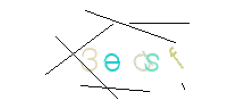

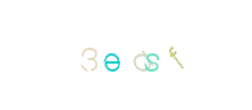

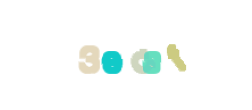

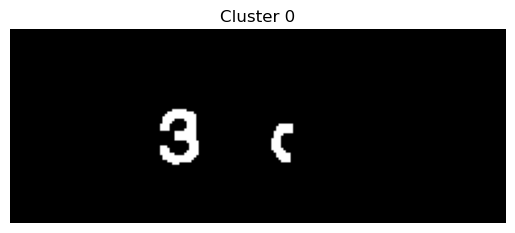

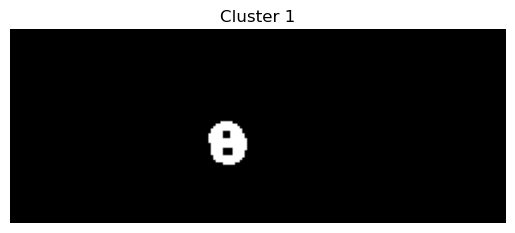

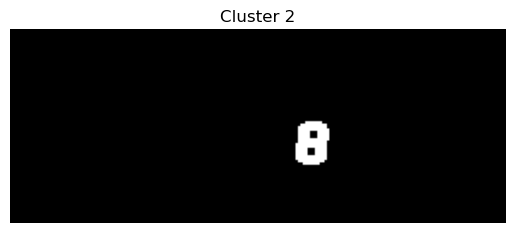

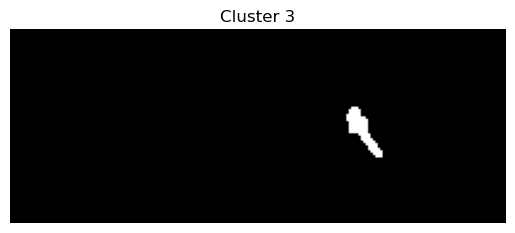

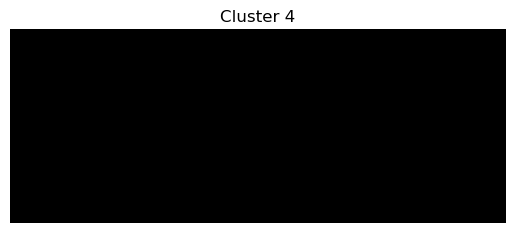

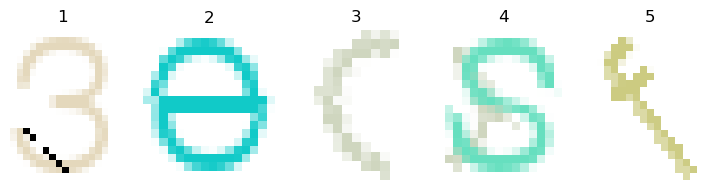

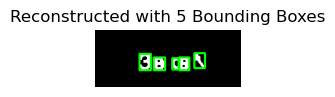

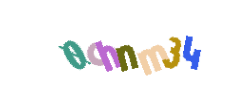

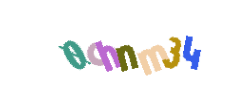

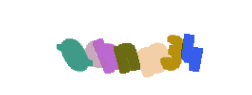

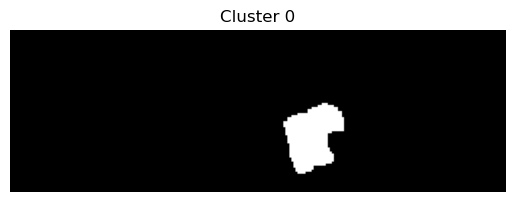

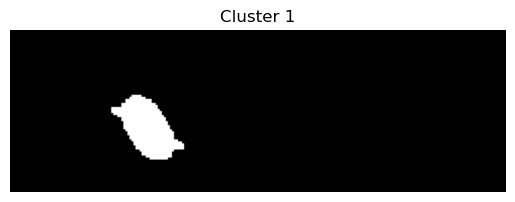

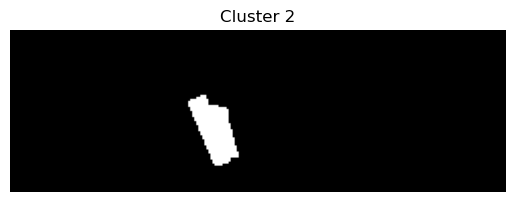

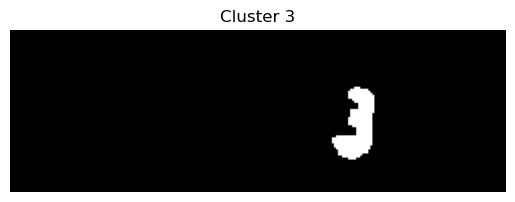

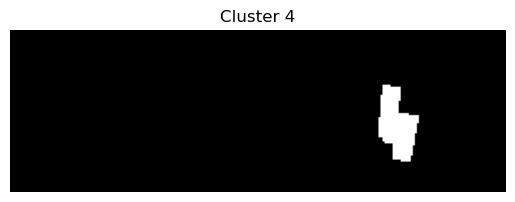

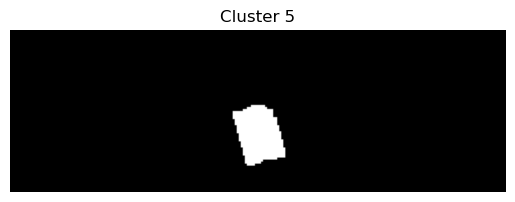

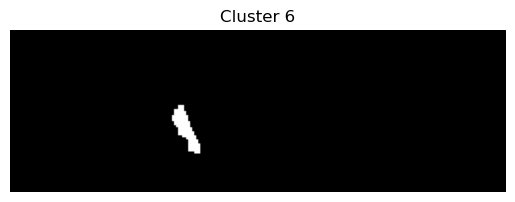

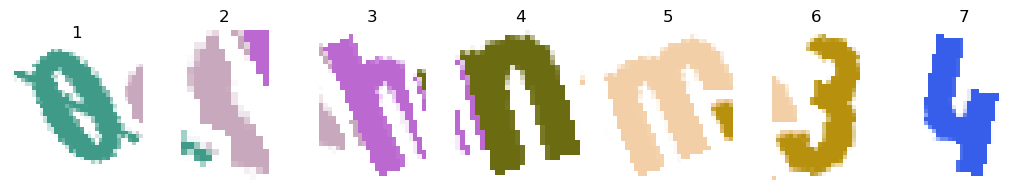

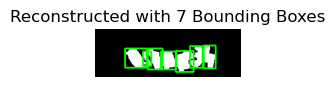

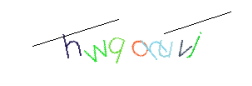

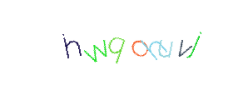

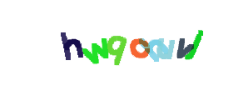

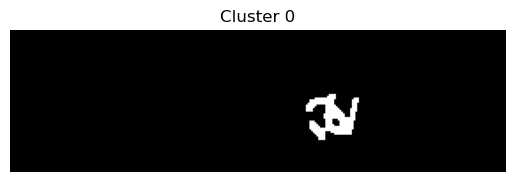

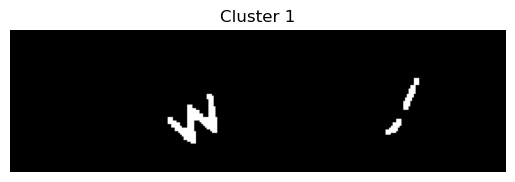

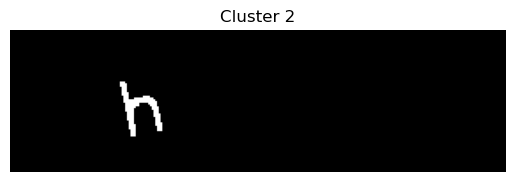

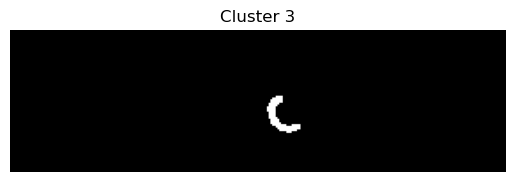

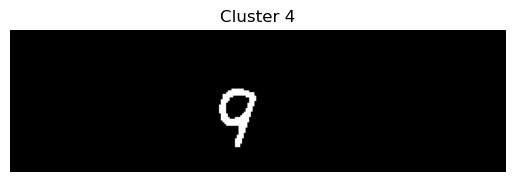

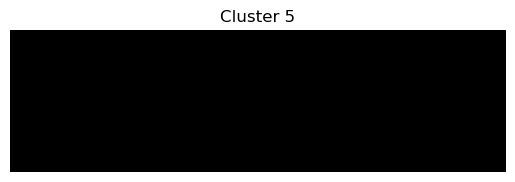

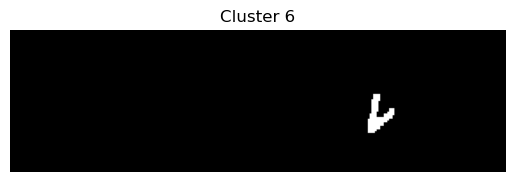

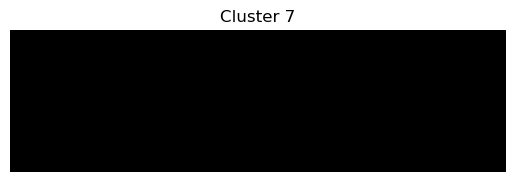

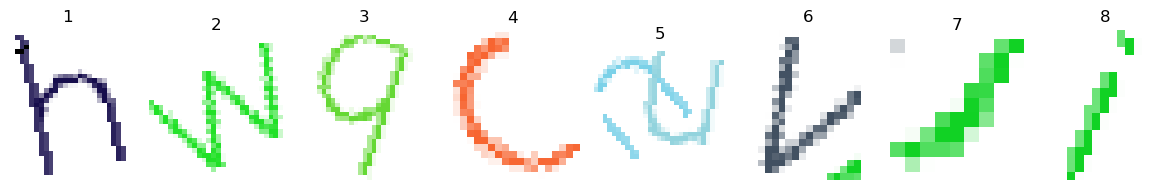

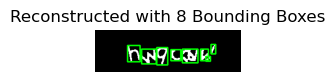

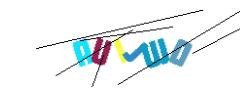

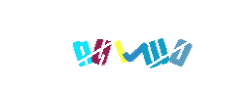

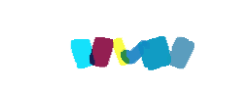

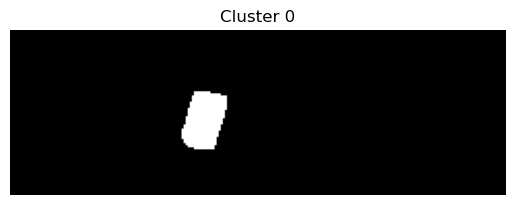

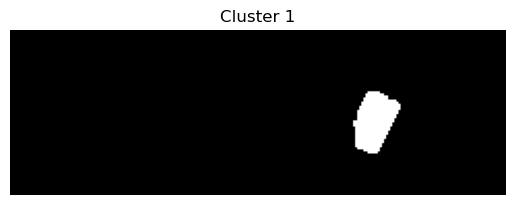

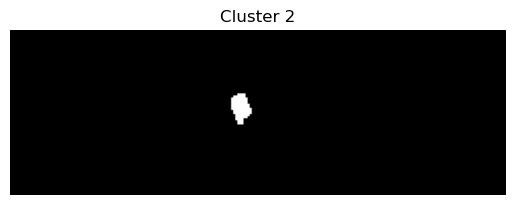

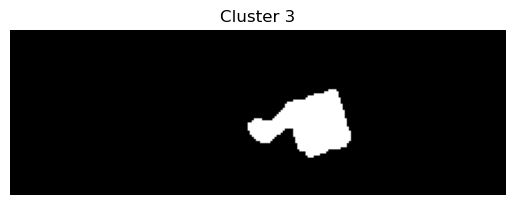

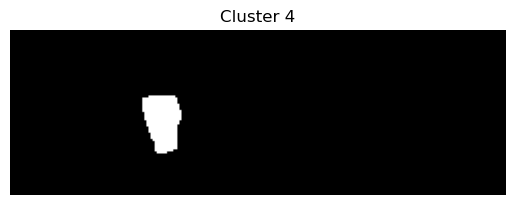

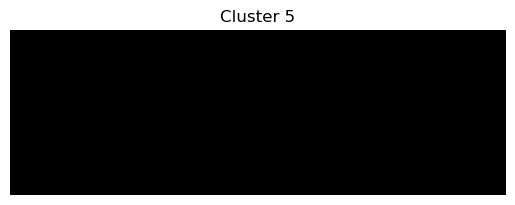

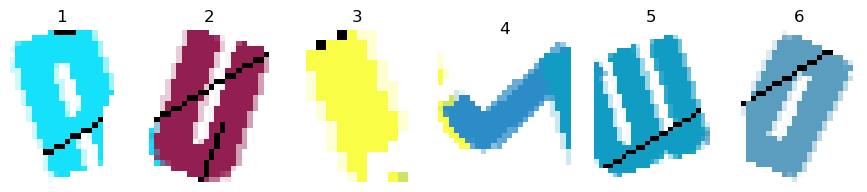

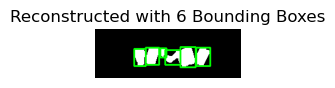

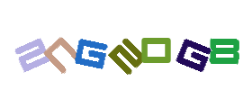

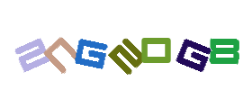

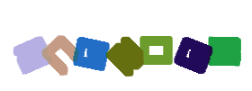

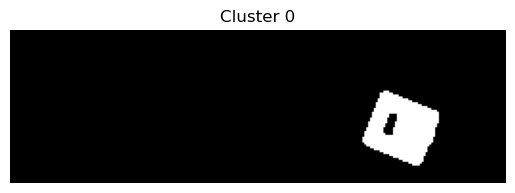

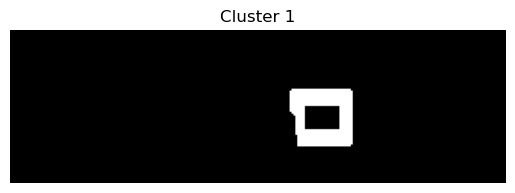

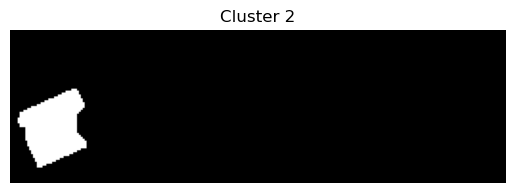

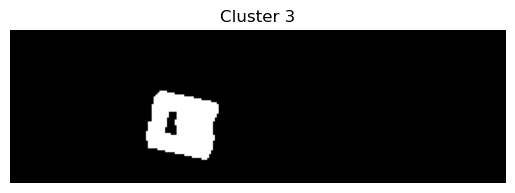

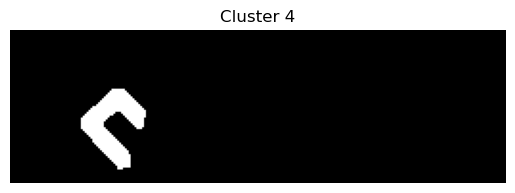

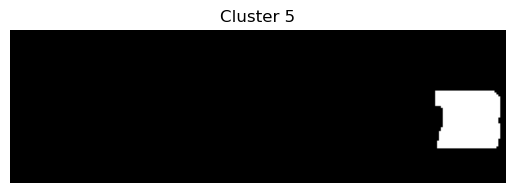

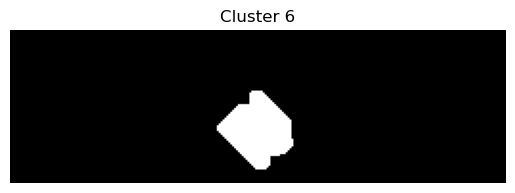

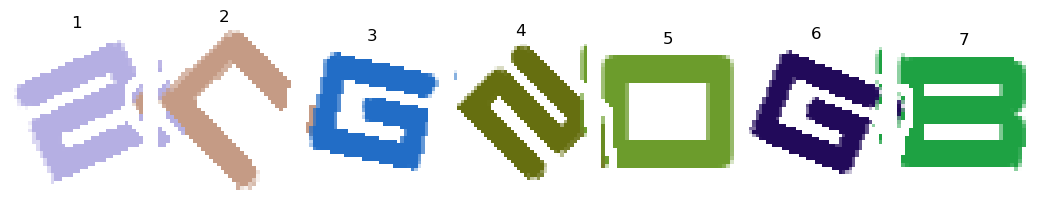

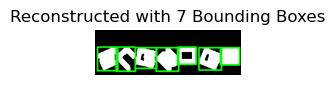

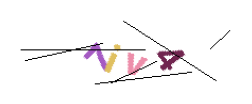

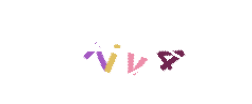

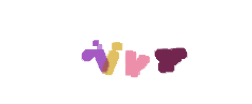

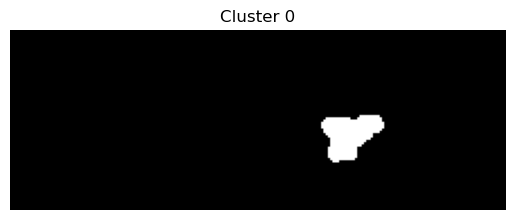

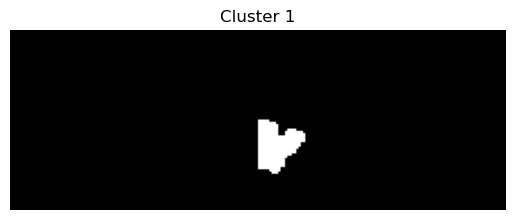

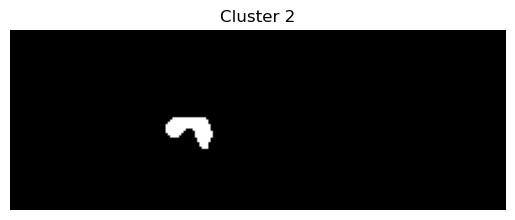

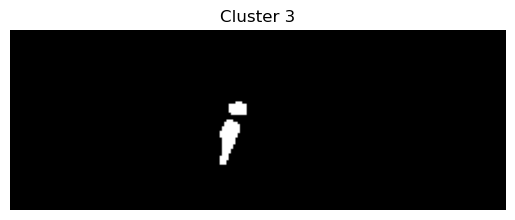

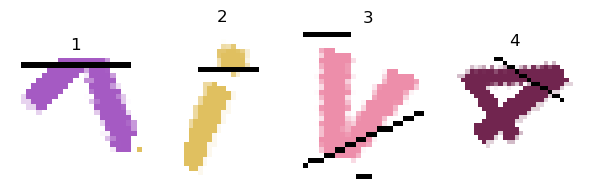

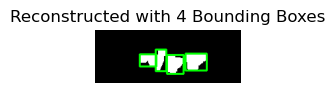

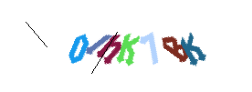

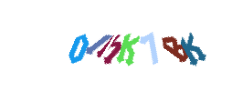

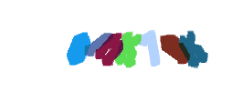

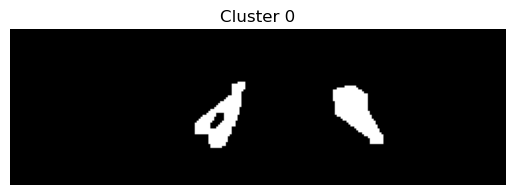

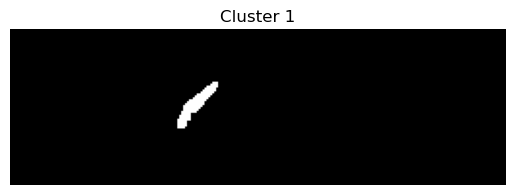

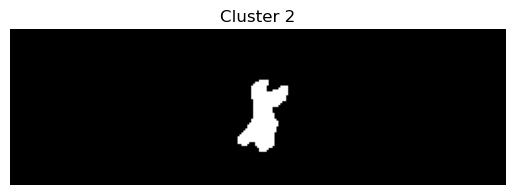

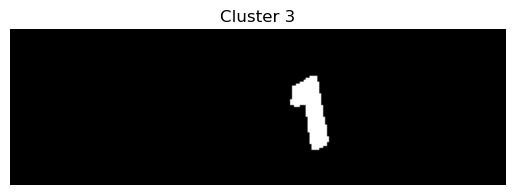

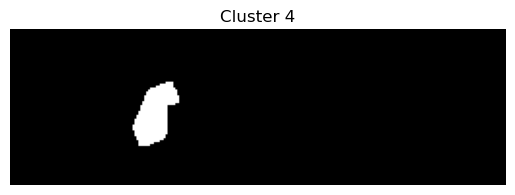

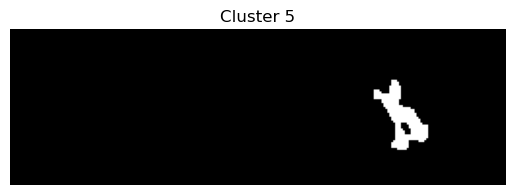

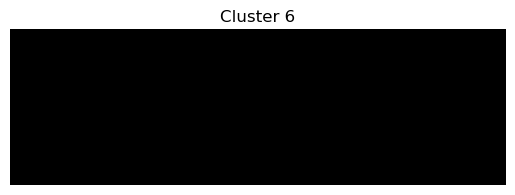

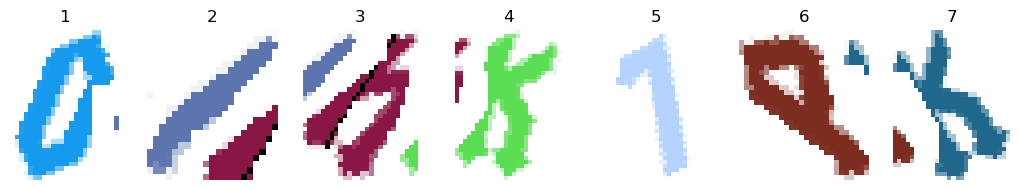

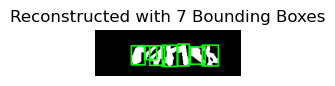

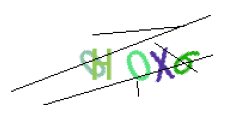

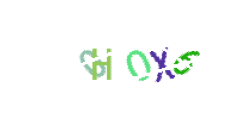

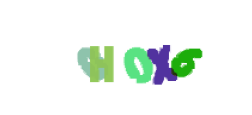

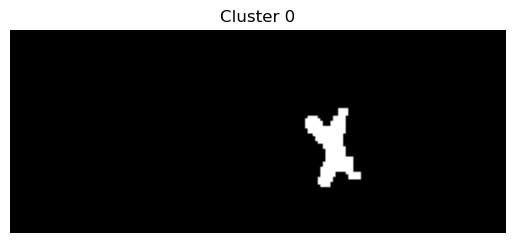

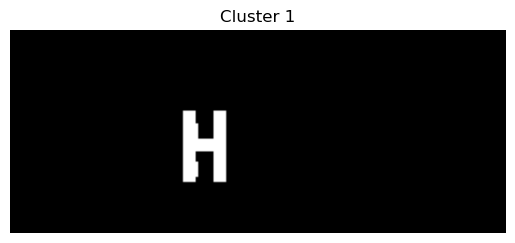

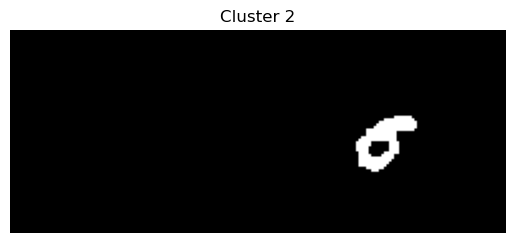

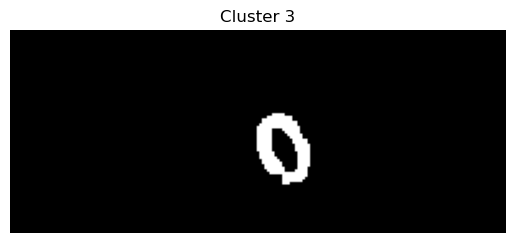

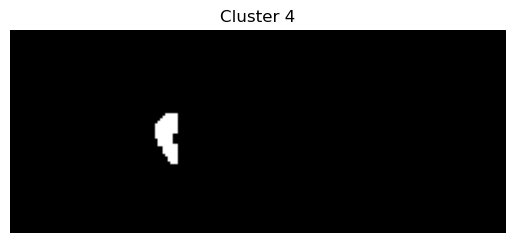

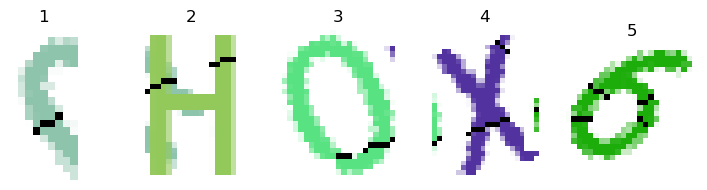

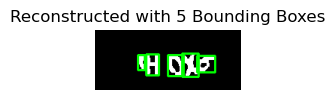

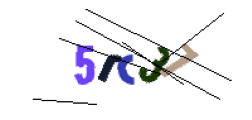

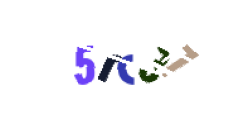

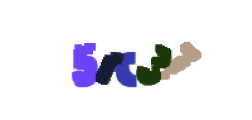

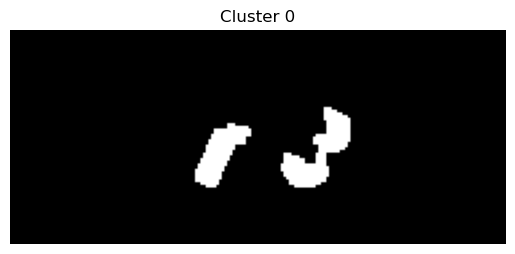

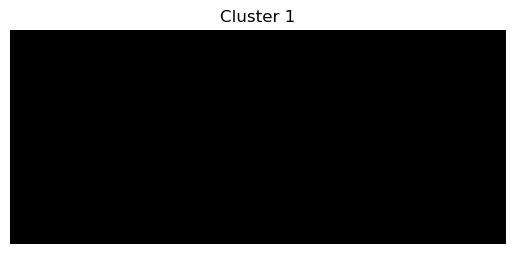

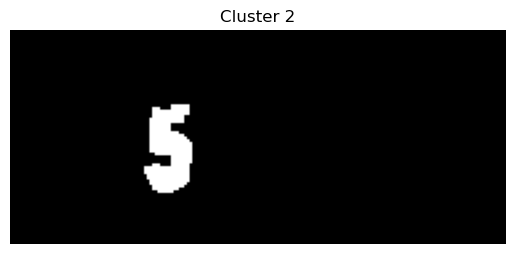

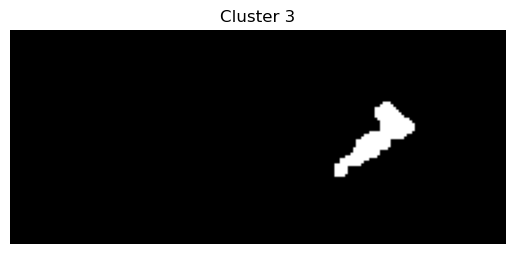

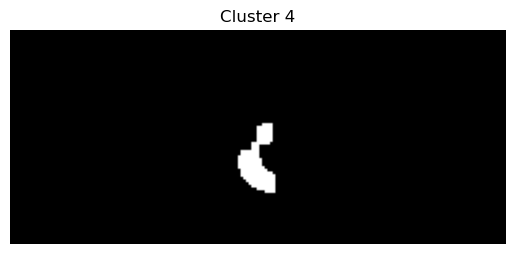

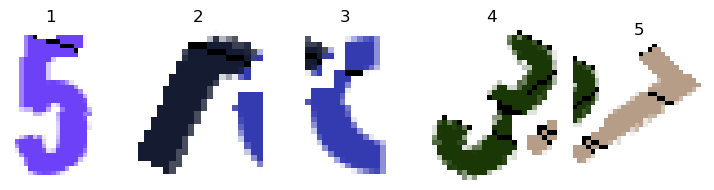

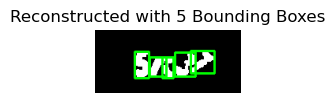

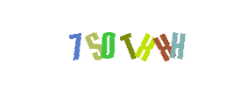

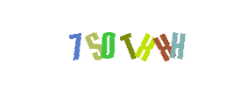

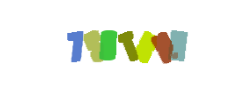

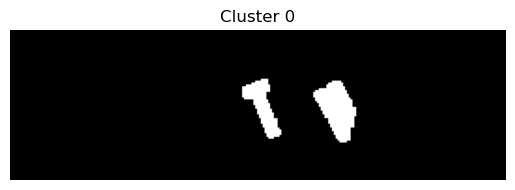

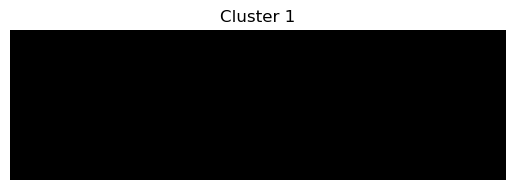

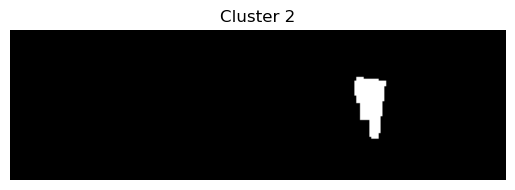

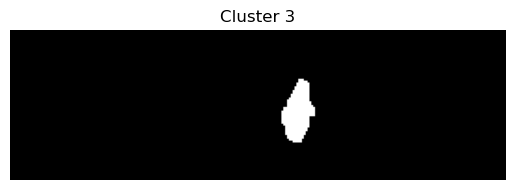

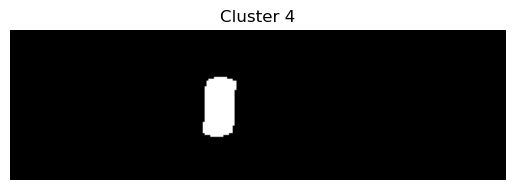

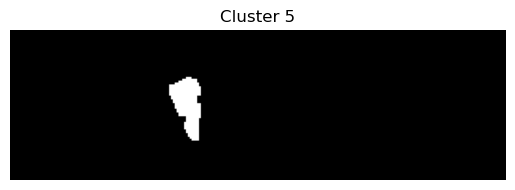

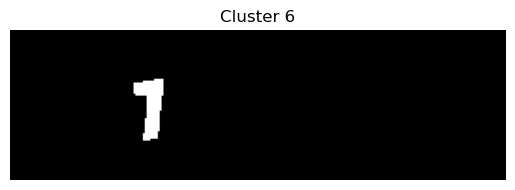

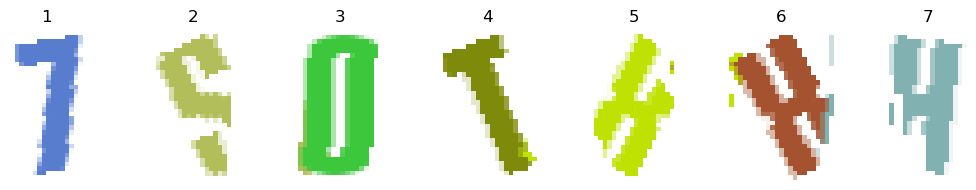

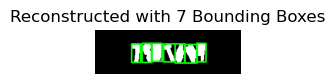

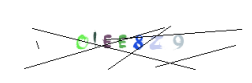

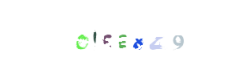

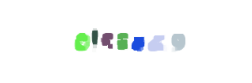

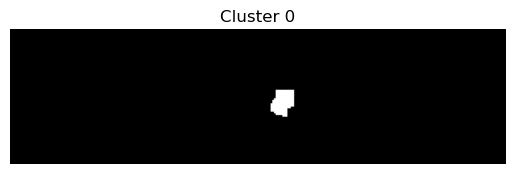

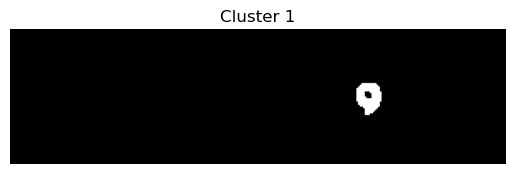

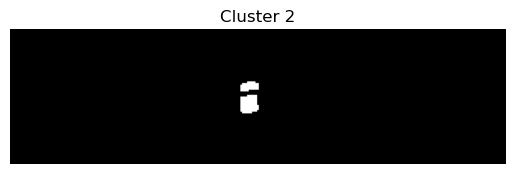

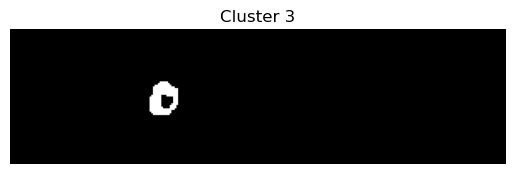

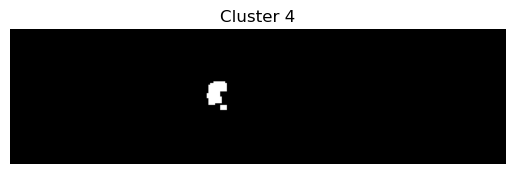

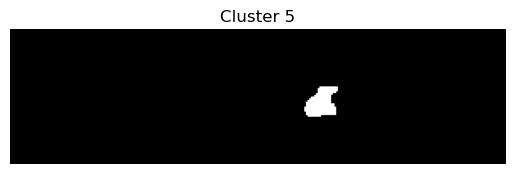

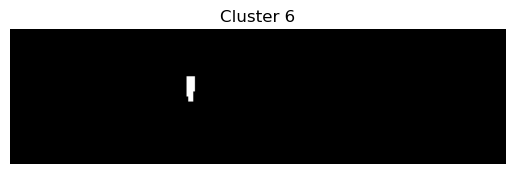

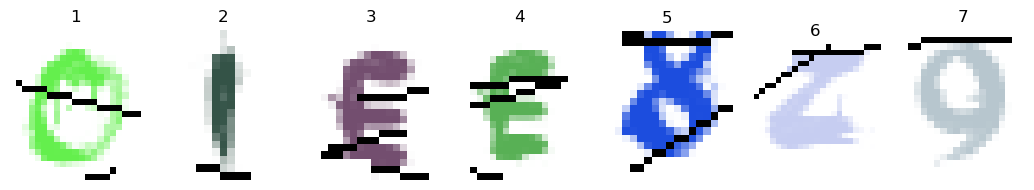

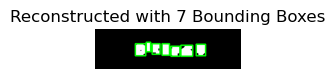

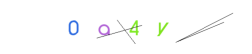

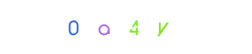

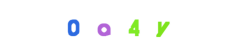

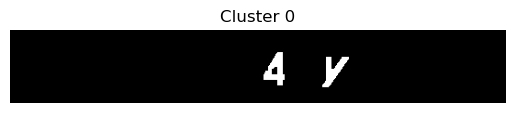

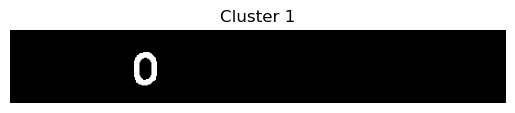

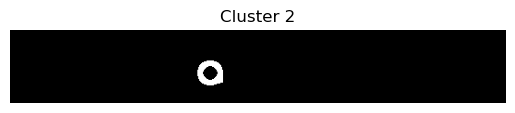

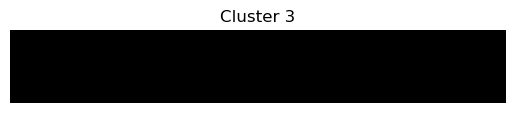

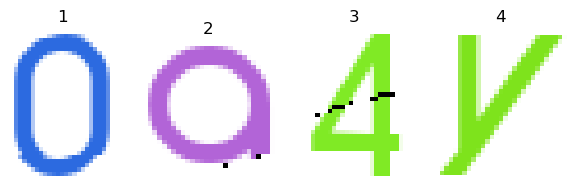

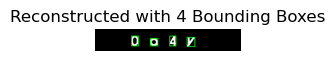

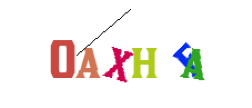

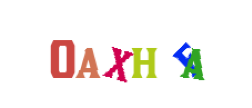

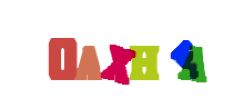

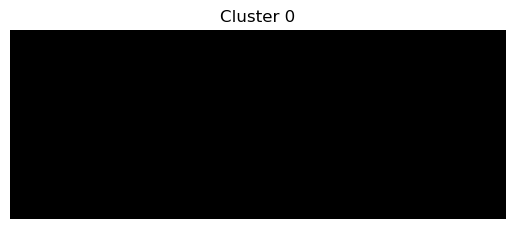

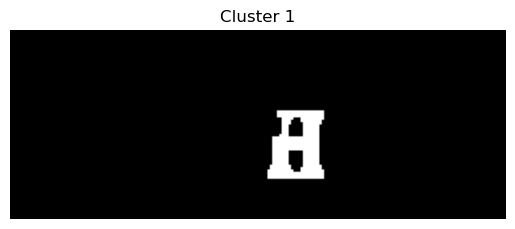

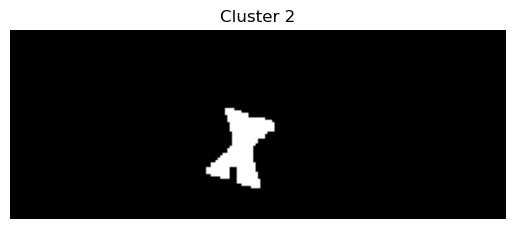

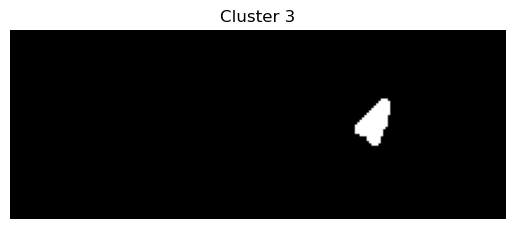

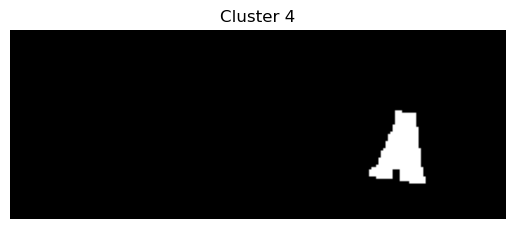

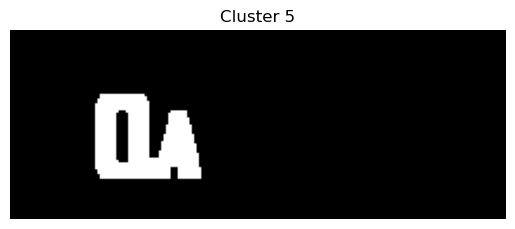

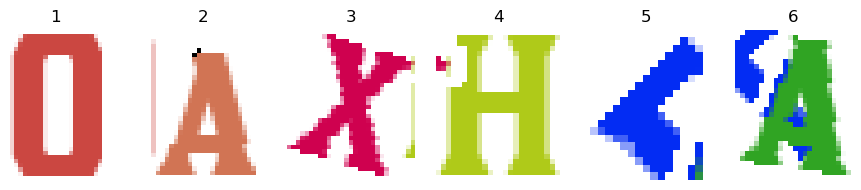

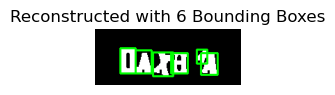

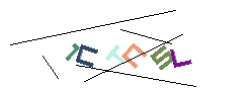

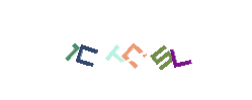

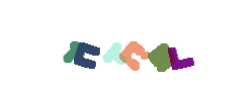

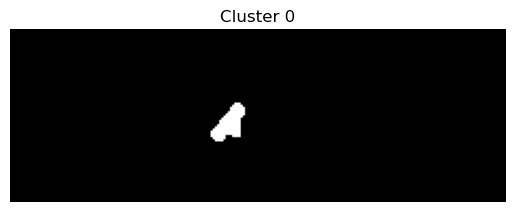

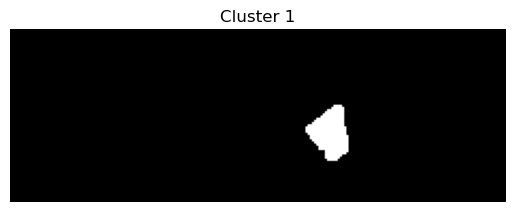

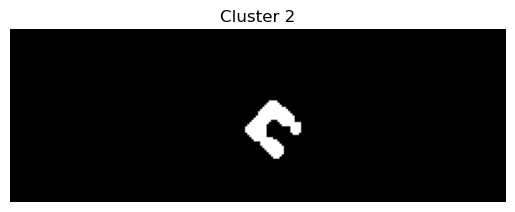

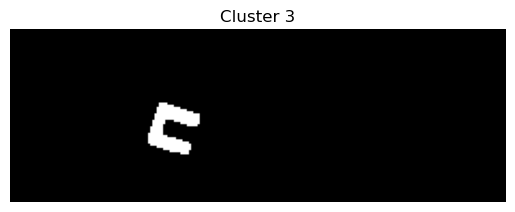

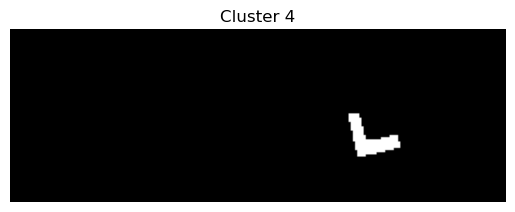

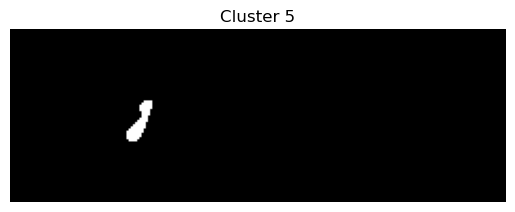

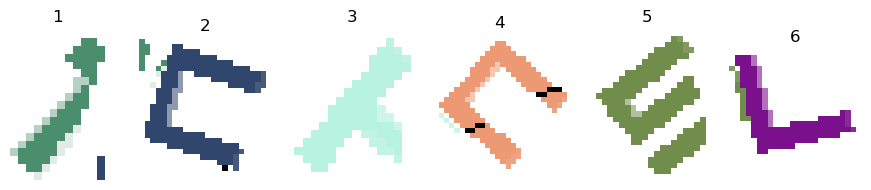

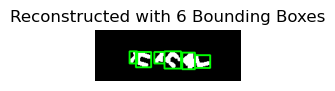

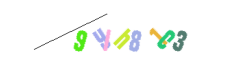

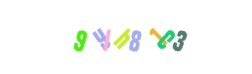

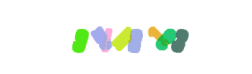

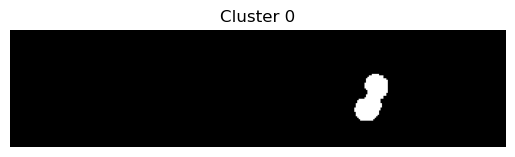

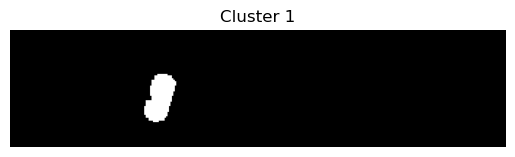

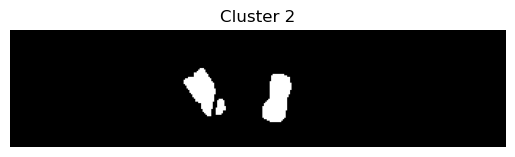

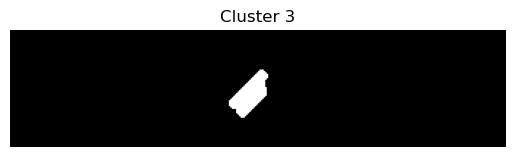

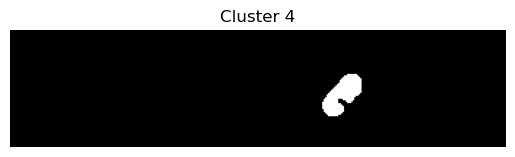

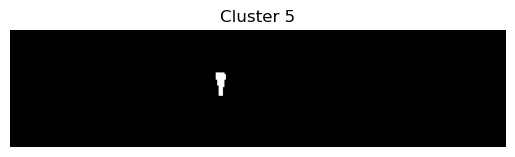

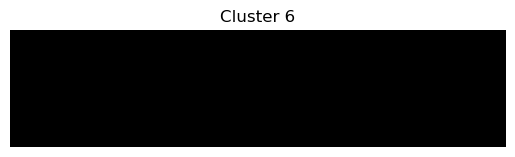

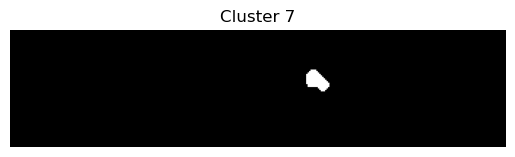

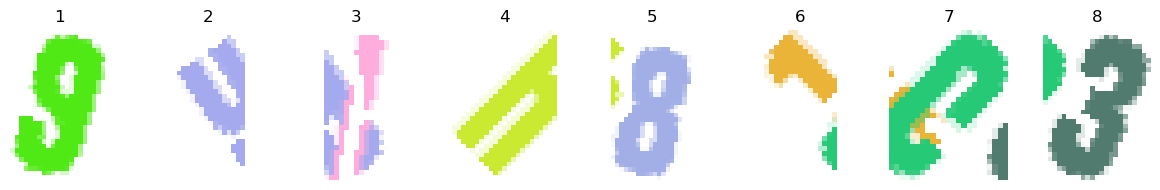

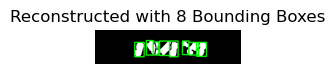

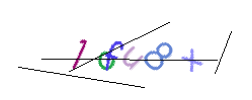

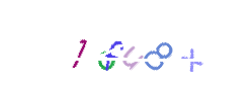

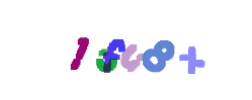

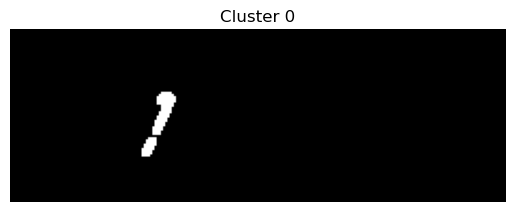

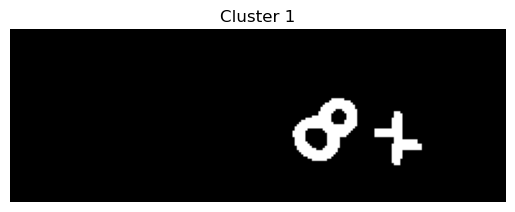

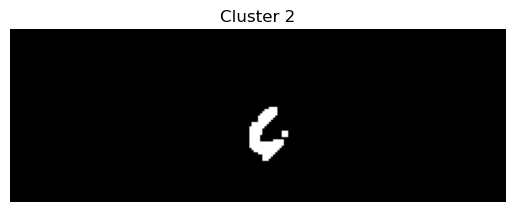

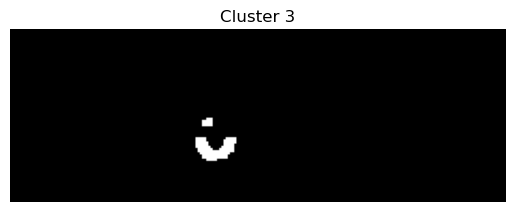

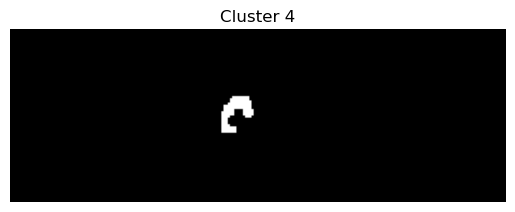

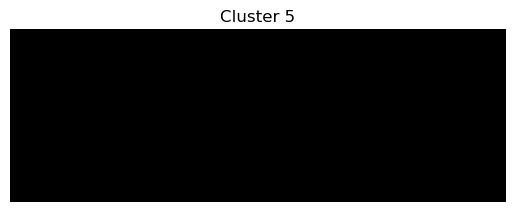

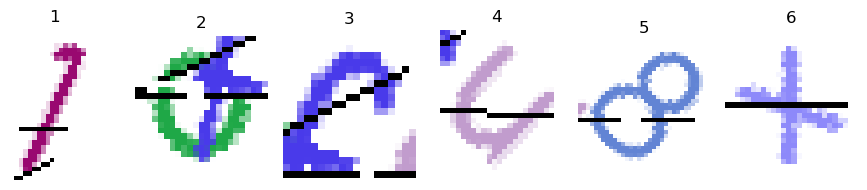

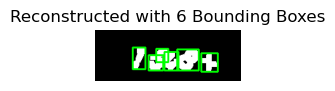

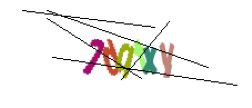

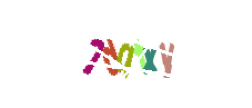

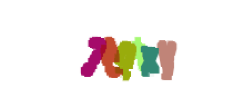

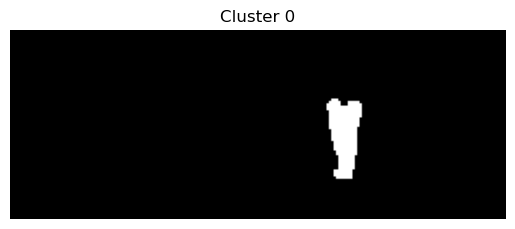

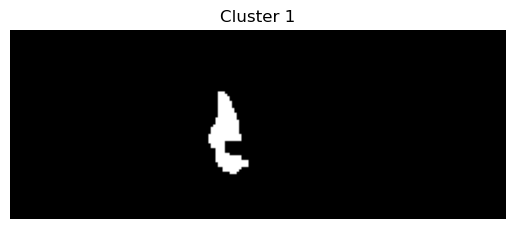

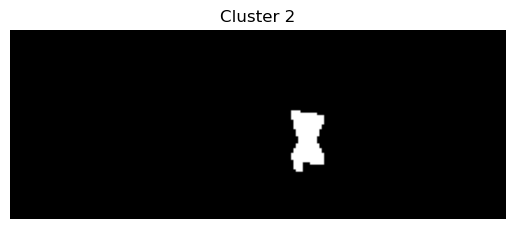

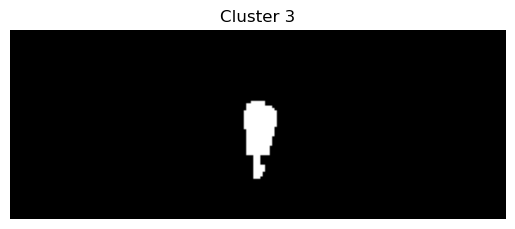

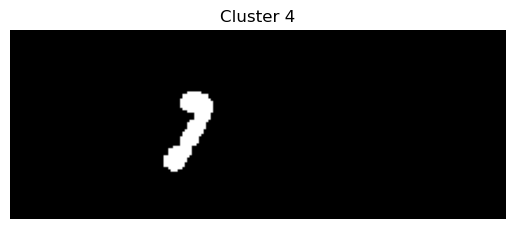

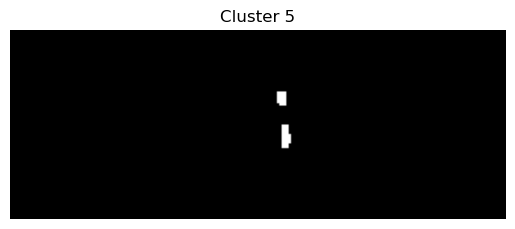

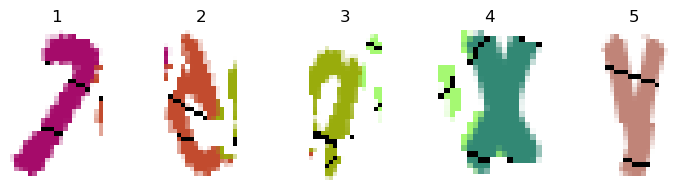

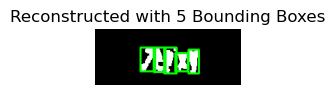

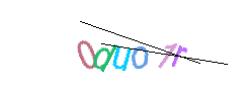

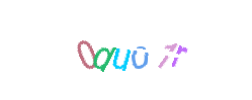

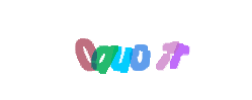

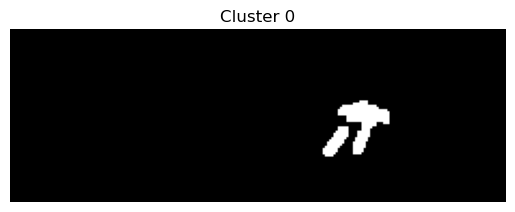

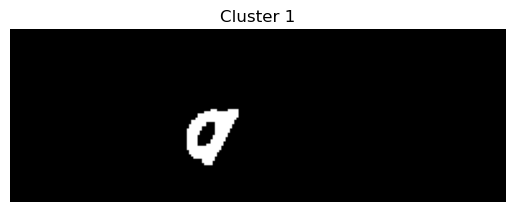

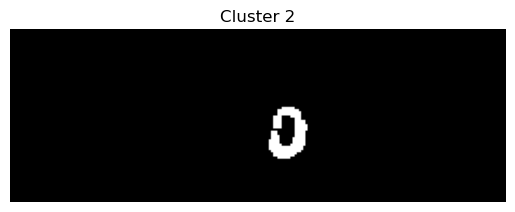

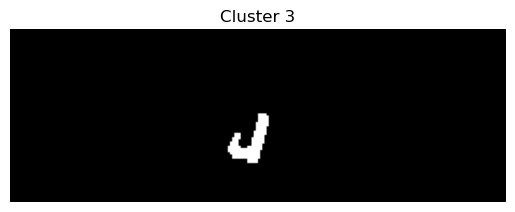

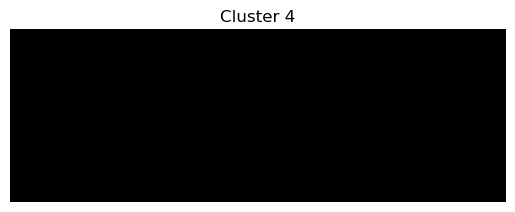

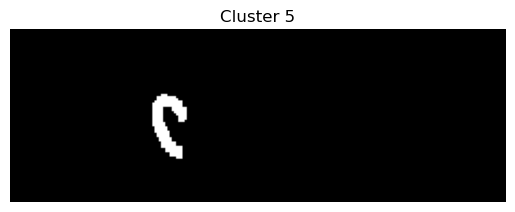

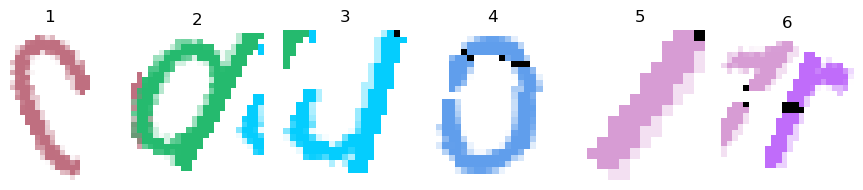

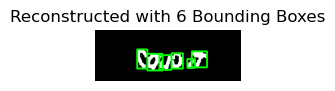

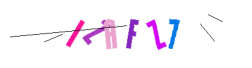

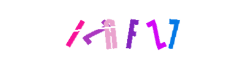

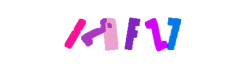

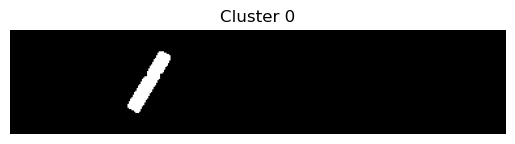

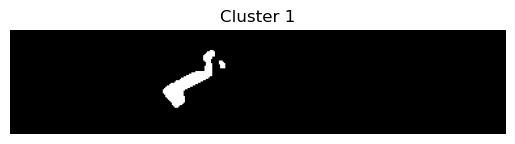

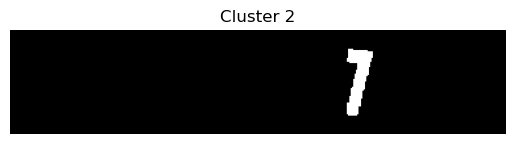

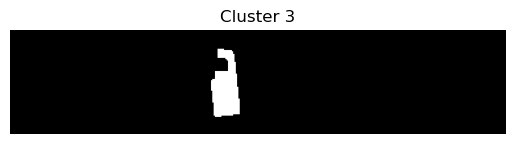

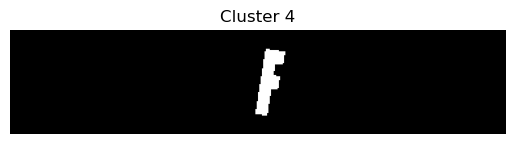

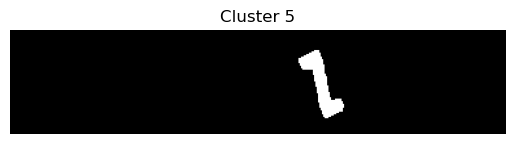

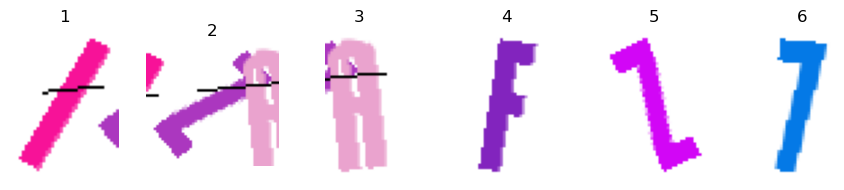

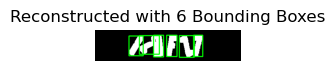

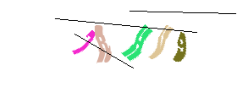

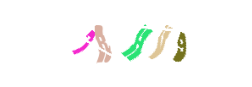

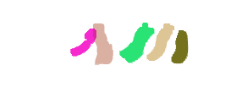

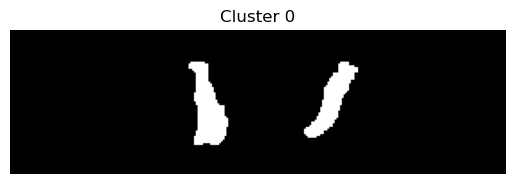

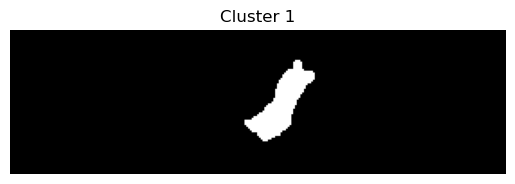

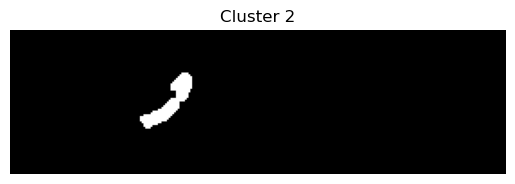

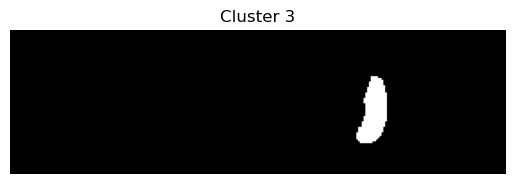

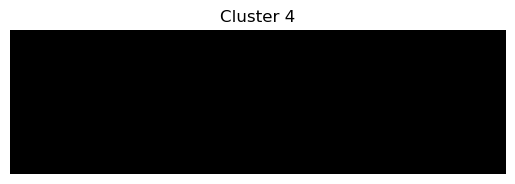

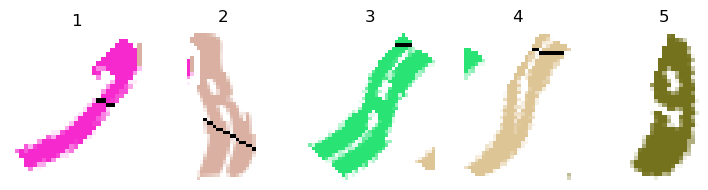

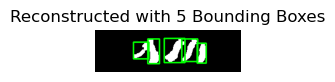

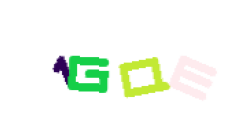

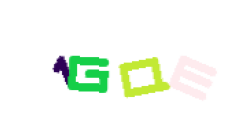

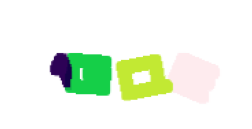

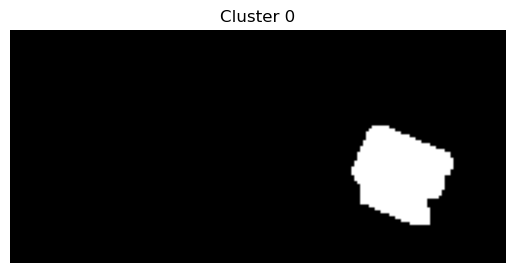

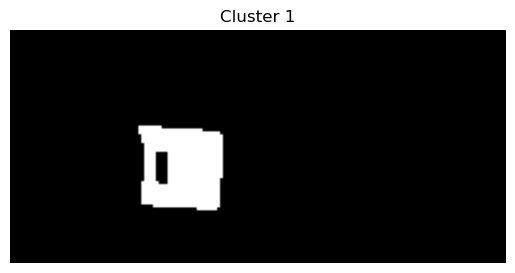

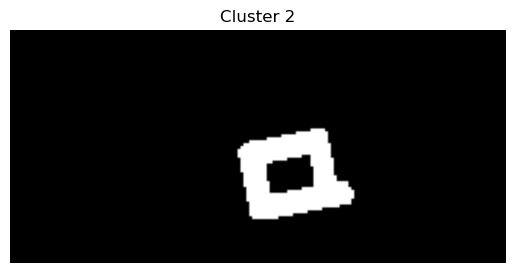

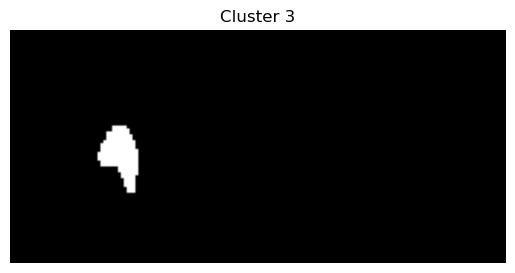

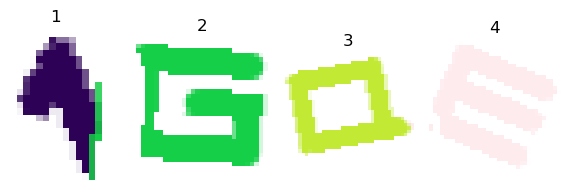

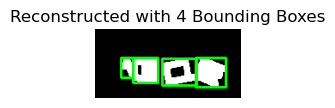

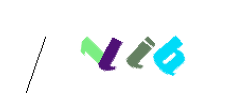

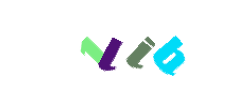

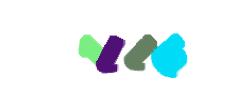

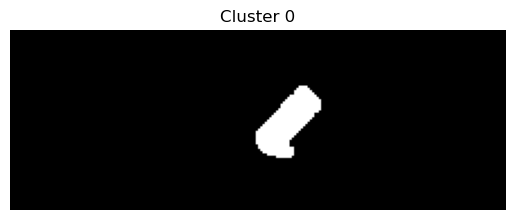

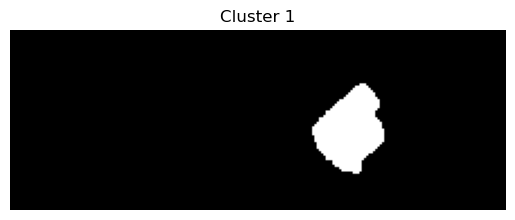

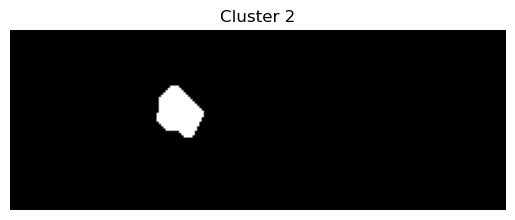

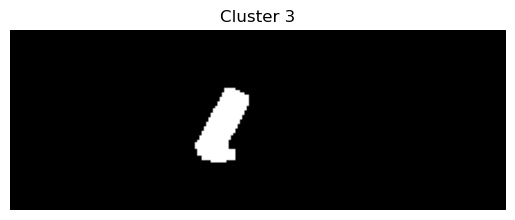

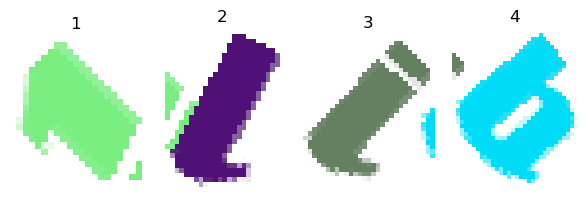

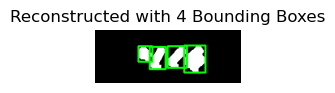

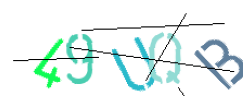

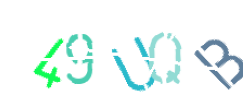

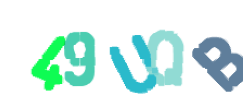

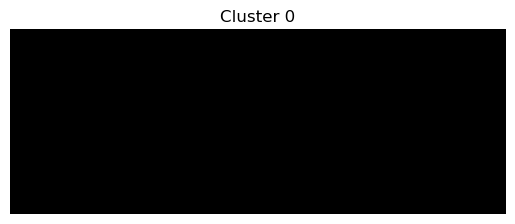

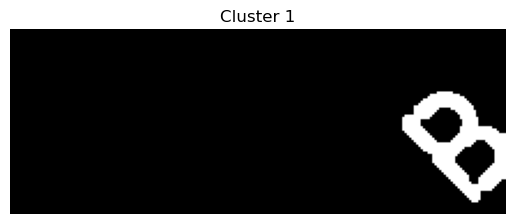

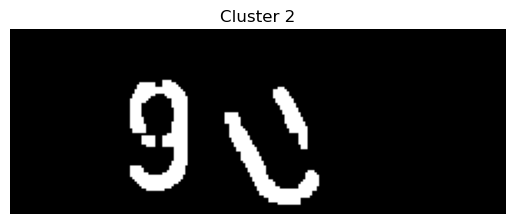

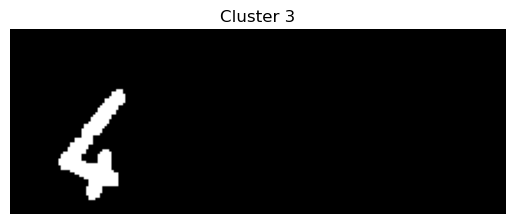

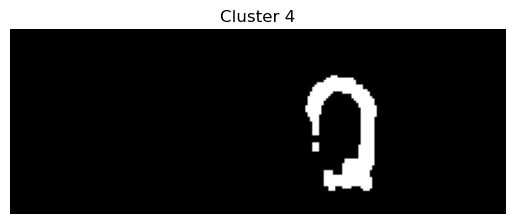

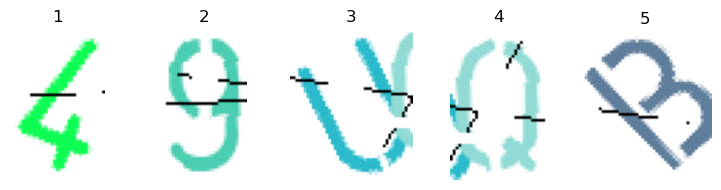

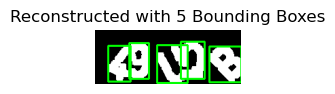

In [14]:
def run(mode: int):
    folder_path = 'captchaImages'
    filenames = os.listdir(folder_path)

    mismatch_count = 0
    smaller_count = 0
    larger_count = 0

    if mode == 1:
        mismatch_filenames = []
        for filename in tqdm(filenames, desc="Processing images"):
            try:
                image_path = os.path.join(folder_path, filename)
                match = process_image(image_path)
                if match != 'correct':
                    mismatch_count += 1
                    if match == 'smaller':
                        smaller_count += 1
                    else:
                        larger_count += 1
                    mismatch_filenames.append(filename)
            except Exception as e:
                mismatch_filenames.append(f"Error: {filename}")
                print(f"Error processing {filename}: {e}")

        print(f"Mismatch count: {mismatch_count}")
        print(f"Smaller count: {smaller_count}")
        print(f"Larger count: {larger_count}")

        # Save mismatch filenames to a text file
        with open("mismatches_4.txt", "w") as f:
            for name in mismatch_filenames:
                f.write(name + "\n")

    elif mode == 2:
        # Read image filenames from mismatches.txt and process them
        # with open("mismatches_4.txt", "r") as f:
        #     image_paths = [line.strip() for line in f if line.strip()]
        #     total_files = len(image_paths)
        # for image_path in image_paths[:5]:
        #     match = process_image(os.path.–join('data/train', image_path), show_images=True)
        #     if match != 'correct':
        #         mismatch_count += 1
        #         if match == 'smaller':
        #             smaller_count += 1
        #         else:
        #             larger_count += 1

        # Added this part: will ignore any subfolder inside captchaImages
        VALID_IMG_EXTS = {".png"}

        for entry in os.scandir(folder_path):
            if not entry.is_file():       
                continue
            if os.path.splitext(entry.name)[1].lower() not in VALID_IMG_EXTS:
                continue

            match = process_image(entry.path, show_images=True)

run(2)